# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



### Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# # Start with some standard imports.
# import numpy as np
# import matplotlib.pyplot as plt
# from functools import reduce
# import torch
# from torchvision.datasets import MNIST
# from torch.utils.data import Subset
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# # Standard MNIST transform.
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Load MNIST train and test.
# ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
# ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# # Split train into train and validation.
# val_size = 5000
# I = np.random.permutation(len(ds_train))
# ds_val = Subset(ds_train, I[:val_size])
# ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score, classification_report

# # Function to train a model for a single epoch over the data loader.
# def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
#     model.train()
#     losses = []
#     for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
#         xs = xs.to(device)
#         ys = ys.to(device)
#         opt.zero_grad()
#         logits = model(xs)
#         loss = F.cross_entropy(logits, ys)
#         loss.backward()
#         opt.step()
#         losses.append(loss.item())
#     return np.mean(losses)

# # Function to evaluate model over all samples in the data loader.
# def evaluate_model(model, dl, device='cpu'):
#     model.eval()
#     predictions = []
#     gts = []
#     for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
#         xs = xs.to(device)
#         preds = torch.argmax(model(xs), dim=1)
#         gts.append(ys)
#         predictions.append(preds.detach().cpu().numpy())
        
#     # Return accuracy score and classification report.
#     return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
#             classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# # Simple function to plot the loss curve and validation accuracy.
# def plot_validation_curves(losses_and_accs):
#     losses = [x for (x, _) in losses_and_accs]
#     accs = [x for (_, x) in losses_and_accs]
#     plt.figure(figsize=(16, 8))
#     plt.subplot(1, 2, 1)
#     plt.plot(losses)
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Average Training Loss per Epoch')
#     plt.subplot(1, 2, 2)
#     plt.plot(accs)
#     plt.xlabel('Epoch')
#     plt.ylabel('Validation Accuracy')
#     plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
# class MLP(nn.Module):
#     def __init__(self, layer_sizes):
#         super().__init__()
#         self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
#     def forward(self, x):
#         return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [5]:
# # Training hyperparameters.
# device = 'cuda' if torch.cuda.is_available else 'cpu'
# epochs = 100
# lr = 0.0001
# batch_size = 128

# # Architecture hyperparameters.
# input_size = 28*28
# width = 16
# depth = 2

# # Dataloaders.
# dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
# dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
# dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# # Instantiate model and optimizer.
# model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
# opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# # Training loop.
# losses_and_accs = []
# for epoch in range(epochs):
#     loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
#     (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
#     losses_and_accs.append((loss, val_acc))

# # And finally plot the curves.
# plot_validation_curves(losses_and_accs)
# print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from termcolor import colored
import wandb
from sklearn.model_selection import KFold

# wandb.login(key='your_wandb_api_key_here')
dataset = datasets.MNIST(root='dataset/', transform=transforms.ToTensor(), download=True)

In [ ]:
import os # Added for path manipulation
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torch.nn.functional as F
from dataloaders import DistillDataset, get_distill_loaders
torch.backends.cudnn.benchmark = True
import math 
class DLModel:
    """
    A general-purpose wrapper for PyTorch models to streamline training, validation, testing,
    and other common deep learning workflows.

    This class provides functionalities such as:
    - K-fold cross-validation.
    - Single training runs with a validation split.
    - Validation and testing loops.
    - Knowledge distillation from a teacher model.
    - Integration with Weights & Biases for logging.
    - Early stopping to prevent overfitting.
    - Support for mixed-precision training with `torch.amp.GradScaler`.
    - Customizable data loaders with options for `num_workers`, `pin_memory`, etc.
    - Automatic Softmax application if model outputs are not probabilities.

    Attributes:
        device (torch.device): The device (CPU or CUDA) on which the model and data will be processed.
        model (torch.nn.Module): The PyTorch neural network model.
        optimizer (torch.optim.Optimizer): The optimizer used for training (e.g., Adam, SGD).
        criterion (torch.nn.Module): The loss function (e.g., CrossEntropyLoss).
        epochs (int): The total number of epochs for training.
        batch_size (int): The number of samples per batch.
        dataset (torch.utils.data.Dataset): The complete dataset.
        trainset (torch.utils.data.Dataset): The training subset of the dataset.
        testset (torch.utils.data.Dataset): The testing subset of the dataset.
        wandb_logging (bool): If True, enables logging to Weights & Biases.
        project_name (str): The name of the project for Weights & Biases logging.
        num_workers (int): The number of subprocesses to use for data loading.
        pin_memory (bool): If True, the data loader will copy Tensors into CUDA pinned memory.
        persistent_workers (bool): If True, the data loader workers will not be shut down after one epoch.
        early_stopping_patience (int): Number of epochs with no improvement after which training will be stopped.
        early_stopping_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        scaler (torch.cuda.amp.GradScaler or None): Gradient scaler for mixed-precision training.
        train_loader (torch.utils.data.DataLoader or None): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader or None): DataLoader for the validation set.
        test_loader (torch.utils.data.DataLoader or None): DataLoader for the test set.
        temperature (float): Temperature parameter used in knowledge distillation.

    Methods:
        train(k_folds=5): Train the model using k-fold cross-validation.
        train_once(val_percent=0.1, reset_weights=True): Train the model once with a validation split.
        validate(): Validate the model on the validation set.
        test(): Test the model on the test set.
        train_once_with_teacher(teacher_outputs_pt, alpha=0.5, alpha_start=0.9, val_percent=0.1, distill_warmup_epochs=20, reset_weights=True, temperature=1.0):
            Train the model using knowledge distillation from a teacher's precomputed outputs.
        set_name(name): Set the project name for Weights & Biases logging.
    """
    
    
    def __init__(self, model=None, dataset=None, optimizer=None, criterion=None, device=None,
                 train_loader=None, val_loader=None, test_loader=None, epochs=None, batch_size=None,
                 trainset=None, testset=None, scheduler=None, wandb_logging=None, project_name=None,
                run_name=None,early_stopping_patience=None, early_stopping_delta=None, num_workers=None,
                 pin_memory=None, persistent_workers=None): 
        self.device = device
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.batch_size = batch_size
        self.dataset = dataset
        self.trainset = trainset
        self.testset = testset
        self.wandb_logging = wandb_logging
        self.project_name = project_name
        self.run_name = run_name
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.persistent_workers = persistent_workers
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_delta = early_stopping_delta
        self.scheduler = scheduler
        self.scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

        # flag to check if model outputs are probabilities        
        self._is_prob = None
        
        self.history = {}
        self.fold_histories = []

    def _reset_history(self, is_distillation=False):
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        if is_distillation:
            self.history['student_loss'] = []
            self.history['distill_loss'] = []
            # 'train_loss' will store the combined loss in distillation

    def _make_loader(self, dataset, shuffle=False, sampler=None):
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            sampler=sampler,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=self.persistent_workers and self.num_workers > 0
        )
    
    @classmethod
    def from_defaults(cls, **kwargs):
        """
        Factory method for creating a DLModel instance using a set of standard or user-supplied default parameters.

        This method should be overridden in each subclass to define meaningful defaults for that model family (e.g., architecture, optimizer, etc.).
        The typical usage is to construct a configuration dictionary (config) from the local parameters and pass it to `cls.generate(config)`,
        which will return the core torch.nn.Module for this wrapper.
        All remaining initialization logic and extra parameters should be passed as kwargs to the class constructor.

        Returns:
            DLModel: An instance of the model wrapper, initialized with the generated PyTorch model and additional parameters.
        """
        config = locals()
        torch_model = cls.generate(config)
        model_wrapper = cls(model=torch_model, **kwargs)
        return model_wrapper

    @staticmethod
    def generate(config):
        """
        Constructs and returns a PyTorch model instance based on the supplied configuration dictionary.

        This method must be implemented in each subclass, and is responsible for building and returning
        the actual torch.nn.Module corresponding to the model architecture and parameters defined in `config`.

        Args:
            config (dict): A dictionary containing all model-relevant parameters.

        Returns:
            torch.nn.Module: The constructed model, ready to be wrapped or trained.
        """
        raise NotImplementedError("The 'generate' method must be implemented in subclasses.")

    def save_model_state(self, filepath):
        """Saves the model's state_dict to the specified filepath."""
        dir_name = os.path.dirname(filepath)
        if dir_name and not os.path.exists(dir_name):
            os.makedirs(dir_name, exist_ok=True)
        torch.save(self.model.state_dict(), filepath)
        print(colored(f"Model state saved to {filepath}", "green"))
       
    def train(self, k_folds=5, auto_save_best_model=False, best_model_filename='best_model.pth'):    
        kfold = KFold(n_splits=k_folds, shuffle=True)
        self.fold_histories = [] # Reset fold histories
        for fold, (train_ids, val_ids) in enumerate(kfold.split(self.trainset)):
            print(f'FOLD {fold}')
            print('--------------------------------')

            current_fold_history = {
                'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []
            }

            train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)

            self.train_loader = self._make_loader(self.trainset, sampler=train_sampler)
            self.val_loader   = self._make_loader(self.trainset, sampler=val_sampler)

            self.model.apply(self._reset_weights)

            if self.wandb_logging:
                wandb.init(project=self.project_name, reinit=True, name=f'{self.run_name}_fold_{fold}')
                wandb.watch(self.model, log="all")

            best_val_acc = 0.0
            epochs_no_improve = 0

            for epoch in range(self.epochs):
                self.model.train()
                running_train_loss = 0.0
                total_train_samples = 0
                for data, targets in self.train_loader:
                    data = data.to(self.device, non_blocking=True)
                    targets = targets.to(self.device, non_blocking=True)

                    self.optimizer.zero_grad()
                    with torch.amp.autocast("cuda", enabled=self.scaler is not None):
                        outputs = self.model(data)
                        # probability check only on the first batch
                        if self._is_prob is None:
                            with torch.no_grad():
                                sums = outputs.sum(dim=1)
                                if torch.all((outputs >= 0) & (outputs <= 1)) and torch.allclose(sums, torch.ones_like(sums), atol=1e-3):
                                    self._is_prob = True
                                else:
                                    self._is_prob = False
                        if not self._is_prob:
                            outputs = F.softmax(outputs, dim=1)

                        loss = self.criterion(outputs, targets)

                    if self.scaler:
                        self.scaler.scale(loss).backward()
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                    else:
                        loss.backward()
                        self.optimizer.step()
                    
                    running_train_loss += loss.item() * data.size(0)
                    total_train_samples += data.size(0)

                epoch_train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else 0.0

                if self.scheduler is not None:
                    self.scheduler.step()

                val_loss, val_acc = self.validate()

                current_fold_history['train_loss'].append(epoch_train_loss)
                current_fold_history['val_loss'].append(val_loss)
                current_fold_history['val_acc'].append(val_acc)
                
                if val_acc > best_val_acc + self.early_stopping_delta:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                    if auto_save_best_model and best_model_filename: # Use local parameters
                        base, ext = os.path.splitext(best_model_filename)
                        fold_model_filename = f"{base}_fold_{fold}{ext}"
                        self.save_model_state(fold_model_filename)
                        print(colored(f"Best model for fold {fold} saved to {fold_model_filename} (Val Acc: {val_acc:.4f})", "cyan"))
                else:
                    epochs_no_improve += 1

                metrics = {"epoch": epoch, "loss": epoch_train_loss, "val_loss": val_loss, "val_acc": val_acc}
                if self.scheduler is not None:
                    current_lr = self.scheduler.get_last_lr()[0]
                    metrics["lr"] = current_lr
                    current_fold_history['lr'].append(current_lr)
                if self.wandb_logging:
                    wandb.log(metrics)
                print(f'Epoch {epoch} | Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}' +
                      (f' | LR: {metrics["lr"]:.5f}' if "lr" in metrics else ''))

                if epochs_no_improve >= self.early_stopping_patience:
                    print(f'Early stopping triggered after {epoch+1} epochs without improvement.')
                    break
            
            self.fold_histories.append(current_fold_history) # Store history for the current fold
            if self.wandb_logging:
                wandb.finish()
            print('--------------------------------')

    def train_once(self, val_percent=0.1, reset_weights=True, auto_save_best_model=False, best_model_filename='best_model.pth'):
        train_size = int((1 - val_percent) * len(self.trainset))
        val_size = len(self.trainset) - train_size
        train_sub, val_sub = torch.utils.data.random_split(self.trainset, [train_size, val_size])

        self.train_loader = self._make_loader(train_sub, shuffle=True)
        self.val_loader   = self._make_loader(val_sub)

        if reset_weights:
            self.model.apply(self._reset_weights)

        self._reset_history() # Reset history for this run

        if self.wandb_logging:
            wandb.init(project=self.project_name, reinit=True,name=self.run_name)
            wandb.watch(self.model, log="all")

        best_val_acc = 0.0
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            total_samples = 0
            for data, targets in self.train_loader:
                data = data.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                self.optimizer.zero_grad()
                with torch.amp.autocast("cuda", enabled=self.scaler is not None):
                    outputs = self.model(data)
                    if self._is_prob is None:
                        with torch.no_grad():
                            sums = outputs.sum(dim=1)
                            if torch.all((outputs >= 0) & (outputs <= 1)) and torch.allclose(sums, torch.ones_like(sums), atol=1e-3):
                                self._is_prob = True
                            else:
                                self._is_prob = False
                    if not self._is_prob:
                        outputs = F.softmax(outputs, dim=1)

                    loss = self.criterion(outputs, targets)

                if self.scaler:
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    loss.backward()
                    self.optimizer.step()

                running_loss += loss.item() * data.size(0)
                total_samples += data.size(0)

            epoch_loss = running_loss / total_samples

            if self.scheduler is not None:
                self.scheduler.step()

            val_loss, val_acc = self.validate()

            self.history['train_loss'].append(epoch_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if val_acc > best_val_acc + self.early_stopping_delta:
                best_val_acc = val_acc
                epochs_no_improve = 0
                if auto_save_best_model and best_model_filename: # Use local parameters
                    self.save_model_state(best_model_filename)
                    print(colored(f"Best model saved to {best_model_filename} (Val Acc: {val_acc:.4f})", "cyan"))
            else:
                epochs_no_improve += 1

            metrics = {"epoch": epoch, "loss": epoch_loss, "val_loss": val_loss, "val_acc": val_acc}
            if self.scheduler is not None:
                current_lr = self.scheduler.get_last_lr()[0]
                metrics["lr"] = current_lr
                self.history['lr'].append(current_lr)
            if self.wandb_logging:
                wandb.log(metrics)
            print(f'Epoch {epoch} | Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}' +
                (f' | LR: {metrics["lr"]:.5f}' if self.scheduler else ''))

            if epochs_no_improve >= self.early_stopping_patience:
                print(f'Early stopping triggered after {epoch+1} epochs, because of no improvement in the latest {self.early_stopping_patience} epochs.')
                break


        if self.wandb_logging:
            wandb.finish()

    def validate(self):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        correct = 0

        with torch.no_grad():
            for data, targets, *other in self.val_loader:
                data = data.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                with torch.amp.autocast("cuda", enabled=self.scaler is not None):
                    scores = self.model(data)
                    if self._is_prob is None:
                        sums = scores.sum(dim=1)
                        if torch.all((scores >= 0) & (scores <= 1)) and torch.allclose(sums, torch.ones_like(sums), atol=1e-3):
                            self._is_prob = True
                        else:
                            self._is_prob = False
                    if not self._is_prob:
                        scores = F.softmax(scores, dim=1)

                    batch_loss = self.criterion(scores, targets)
                    total_loss += batch_loss.item() * data.size(0)

                pred = scores.argmax(dim=1, keepdim=True)
                correct += pred.eq(targets.view_as(pred)).sum().item()
                total_samples += data.size(0)

        val_loss = total_loss / total_samples
        val_acc  = correct / total_samples
        return val_loss, val_acc

    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        self.test_loader = self._make_loader(self.testset, shuffle=False)
        with torch.no_grad():
            for data, targets in self.test_loader:
                data = data.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)
                with torch.amp.autocast("cuda", enabled=self.scaler is not None):
                    scores = self.model(data)
                    if self._is_prob is None:
                        sums = scores.sum(dim=1)
                        if torch.all((scores >= 0) & (scores <= 1)) and torch.allclose(sums, torch.ones_like(sums), atol=1e-3):
                            self._is_prob = True
                        else:
                            self._is_prob = False
                    if not self._is_prob:
                        scores = F.softmax(scores, dim=1)

                    test_loss += self.criterion(scores, targets).item()

                pred = scores.argmax(dim=1, keepdim=True)
                correct += pred.eq(targets.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.sampler)
        test_acc = correct / len(self.test_loader.sampler)
        print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')
        return test_loss, test_acc

    def train_once_with_teacher(self,
                                teacher_outputs_pt,
                                alpha_final: float = 0.5, 
                                alpha_start: float = 0.9,
                                val_percent: float = 0.1,
                                distill_warmup_epochs: int = 20,
                                reset_weights: bool = True,
                                temperature: float = 1.0,
                                auto_save_best_model=False, 
                                best_model_filename='best_model_distilled.pth',):
        """
        Train the student model using knowledge distillation from a teacher's precomputed outputs.
        Args:
            teacher_outputs_pt (torch.Tensor): Precomputed outputs from the teacher model.
            alpha_final (float): Final weighting factor for the student loss vs distillation loss.
                           Loss = current_alpha * (student_loss * T^2) + (1 - current_alpha) * distill_loss.
            alpha_start (float): Initial weighting factor for the student loss during warmup annealing.
            val_percent (float): Percentage of training data to use for validation.
            distill_warmup_epochs (int): Number of epochs for alpha annealing from alpha_start to alpha.
            reset_weights (bool): If True, reset model weights before training.
            temperature (float): Temperature parameter used in knowledge distillation. T in T^2 scaling.
        """
        self.temperature = temperature
        

        # This function is defined in the dataloaders module... if defined in the same file,
        # the notebook gets stuck. I reckon it's an issue with num workers and pin_memory.
        self.train_loader, self.val_loader = get_distill_loaders(
            self.trainset, teacher_outputs_pt, self.batch_size, val_percent=val_percent,
            num_workers=self.num_workers, pin_memory=self.pin_memory
        )

        if reset_weights:
            self.model.apply(self._reset_weights)

        self._reset_history(is_distillation=True) # Reset history for distillation run

        if self.wandb_logging:
            wandb.init(project=self.project_name, reinit=True, name=f'{self.run_name}')
            wandb.watch(self.model, log="all")

        best_val_acc = 0.0
        epochs_no_improve = 0
        T = getattr(self, 'temperature', 1.0)

        for epoch in range(self.epochs):
            self.model.train()
            running_combined_loss = 0.0
            running_student_loss = 0.0
            running_distill_loss = 0.0
            total_samples_epoch = 0

            # Alpha annealing
            if distill_warmup_epochs > 0 and epoch < distill_warmup_epochs:
                cosine_term = math.cos(math.pi * epoch / (2 * distill_warmup_epochs))
                current_alpha = alpha_final + (alpha_start - alpha_final) * (cosine_term ** 2)
            else:
                current_alpha = alpha_final
            
            for data, targets, teacher_logits in self.train_loader:
                data, targets, teacher_logits = data.to(self.device), targets.to(self.device), teacher_logits.to(self.device)

                self.optimizer.zero_grad()
                with torch.amp.autocast(device_type="cuda", enabled=(self.scaler is not None)):
                    outputs_logits = self.model(data)

                    if self._is_prob is None:
                        with torch.no_grad():
                            sums = outputs_logits.sum(dim=1)
                            self._is_prob = (
                                torch.all((outputs_logits >= 0) & (outputs_logits <= 1))
                                and torch.allclose(sums, torch.ones_like(sums), atol=1e-3)
                            )
                    if not self._is_prob:
                        outputs_softmax = F.softmax(outputs_logits, dim=1) # Use softmax for criterion if model outputs logits
                    else:
                        outputs_softmax = outputs_logits # Already probabilities

                    loss_student = self.criterion(outputs_softmax, targets) # Hard loss
                    
                    # Soft loss (distillation)
                    log_p_student = F.log_softmax(outputs_logits / T, dim=1)
                    softmax_p_teacher = F.softmax(teacher_logits / T, dim=1)
                    loss_distill = F.kl_div(log_p_student, softmax_p_teacher, reduction='batchmean') * (T * T) # Already scaled by T*T
                    
                    # Combined loss with consistent scaling
                    loss = current_alpha * (loss_student * T * T) + (1.0 - current_alpha) * loss_distill


                if self.scaler:
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    loss.backward()
                    self.optimizer.step()
                
                running_combined_loss += loss.item() * data.size(0)
                running_student_loss += loss_student.item() * data.size(0) # Log unscaled student loss
                running_distill_loss += loss_distill.item() * data.size(0) # Log scaled distill loss (it's already scaled)
                total_samples_epoch += data.size(0)


            if self.scheduler is not None:
                self.scheduler.step()

            val_loss, val_acc = self.validate()
            
            epoch_combined_loss = running_combined_loss / total_samples_epoch if total_samples_epoch > 0 else 0.0
            epoch_student_loss = running_student_loss / total_samples_epoch if total_samples_epoch > 0 else 0.0
            epoch_distill_loss = running_distill_loss / total_samples_epoch if total_samples_epoch > 0 else 0.0

            self.history['train_loss'].append(epoch_combined_loss) # Combined loss
            self.history['student_loss'].append(epoch_student_loss) # Unscaled student loss
            self.history['distill_loss'].append(epoch_distill_loss) # Scaled distillation loss
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if val_acc > best_val_acc + self.early_stopping_delta:
                best_val_acc = val_acc
                epochs_no_improve = 0
                if auto_save_best_model and best_model_filename: # Use local parameters
                    # Potentially add a suffix like '_distilled' to the filename if desired
                    distilled_model_filename = self.best_model_filename 
                    # if not "_distilled" in distilled_model_filename:
                    #     base, ext = os.path.splitext(self.best_model_filename)
                    #     distilled_model_filename = f"{base}_distilled{ext}"
                    self.save_model_state(distilled_model_filename)
                    print(colored(f"Best distilled model saved to {distilled_model_filename} (Val Acc: {val_acc:.4f})", "cyan"))
            else:
                epochs_no_improve += 1

            metrics = {
                'epoch': epoch,
                'student_loss': epoch_student_loss, # Log unscaled student loss
                'distill_loss': epoch_distill_loss, # Log scaled distill loss
                'loss': epoch_combined_loss, # Log combined (scaled) loss
                'val_loss': val_loss,
                'val_acc': val_acc,
                'current_alpha': current_alpha # Log current alpha
            }
            if self.scheduler is not None:
                current_lr = self.scheduler.get_last_lr()[0]
                metrics['lr'] = current_lr
                self.history['lr'].append(current_lr)
            if self.wandb_logging:
                wandb.log(metrics)

            print(
                f"Epoch {epoch} | Loss: {epoch_combined_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
                + (f" | LR: {metrics['lr']:.5f}" if 'lr' in metrics else "")
                + (f" | Alpha: {current_alpha:.3f}" if distill_warmup_epochs > 0 else "") # Display current alpha
            )

            if epochs_no_improve >= self.early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs with no improvement.")
                break

        if self.wandb_logging:
            wandb.finish()


    def plot_training_curves(self, fold_index=None, history_to_plot=None):
        import matplotlib.pyplot as plt
        import seaborn as sns
        sns.set_theme(context='notebook', style='whitegrid', font_scale=1.1)

        history_data = None
        title_prefix = self.run_name if self.run_name else "Run"

        if history_to_plot:
            history_data = history_to_plot
            title_prefix = "Custom History"
        elif fold_index is not None and self.fold_histories and fold_index < len(self.fold_histories):
            history_data = self.fold_histories[fold_index]
            title_prefix = f"{title_prefix} - Fold {fold_index}"
        elif self.history:
            history_data = self.history
        
        if not history_data or not history_data.get('val_loss'): # Check if there's anything to plot
            print("No training history found or history is empty.")
            return

        num_epochs = len(history_data.get('val_loss', []))
        if num_epochs == 0:
            print("No epochs recorded in history.")
            return
            
        epochs_range = range(1, num_epochs + 1)

        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle(f'{title_prefix} Training Curves', fontsize=16, fontweight='bold')

        # Plot Losses
        if 'train_loss' in history_data and history_data['train_loss']:
            axs[0].plot(epochs_range, history_data['train_loss'], label='Training Loss', marker='o', linewidth=2)
        if 'val_loss' in history_data and history_data['val_loss']:
            axs[0].plot(epochs_range, history_data['val_loss'], label='Validation Loss', marker='s', linewidth=2)
        if 'student_loss' in history_data and history_data['student_loss']: # For distillation
            axs[0].plot(epochs_range, history_data['student_loss'], label='Student Loss (Hard)', marker='^', linestyle='--', linewidth=2)
        if 'distill_loss' in history_data and history_data['distill_loss']: # For distillation
            axs[0].plot(epochs_range, history_data['distill_loss'], label='Distillation Loss (Soft)', marker='x', linestyle='--', linewidth=2)
        
        axs[0].set_xlabel('Epochs', fontsize=12)
        axs[0].set_ylabel('Loss', fontsize=12)
        axs[0].set_title('Loss per Epoch', fontsize=14)
        axs[0].legend(fontsize=10)
        axs[0].grid(True, alpha=0.3)
        axs[0].tick_params(axis='both', which='major', labelsize=10)
        axs[0].set_xlim(left=1)


        # Plot Accuracies
        if 'val_acc' in history_data and history_data['val_acc']:
            axs[1].plot(epochs_range, history_data['val_acc'], label='Validation Accuracy', marker='s', color='darkorange', linewidth=2)
        
        axs[1].set_xlabel('Epochs', fontsize=12)
        axs[1].set_ylabel('Accuracy', fontsize=12)
        axs[1].set_title('Accuracy per Epoch', fontsize=14)
        axs[1].legend(fontsize=10)
        axs[1].grid(True, alpha=0.3)
        axs[1].tick_params(axis='both', which='major', labelsize=10)
        axs[1].set_xlim(left=1)
        if history_data.get('val_acc'): # Set y-limit for accuracy if data exists
             min_acc = min(history_data['val_acc']) if history_data['val_acc'] else 0
             max_acc = max(history_data['val_acc']) if history_data['val_acc'] else 1
             axs[1].set_ylim(bottom=max(0, min_acc - 0.05), top=min(1, max_acc + 0.05))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
        plt.show()

    @staticmethod
    def plot_multiple_training_curves(models, title="Comparative Training Curves"):
        import matplotlib.pyplot as plt
        import seaborn as sns
        sns.set_theme(context='notebook', style='whitegrid', font_scale=1.1)

        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        valid_models_count = 0

        # Plot Losses
        for i, model_instance in enumerate(models):
            model_name = model_instance.run_name if model_instance.run_name else f"Model {i+1}"
            history_data = model_instance.history
            
            if not history_data or not history_data.get('val_loss') or not history_data['val_loss']:
                print(colored(f"Warning: No validation loss history found for {model_name}. Skipping this model for loss plot.", "yellow"))
            else:
                num_epochs = len(history_data['val_loss'])
                epochs_range = range(1, num_epochs + 1)
                axs[0].plot(epochs_range, history_data['val_loss'], label=f'{model_name} - Val Loss', marker='o', linewidth=2)
                valid_models_count +=1 # Increment if at least one plot is made

        axs[0].set_xlabel('Epochs', fontsize=12)
        axs[0].set_ylabel('Validation Loss', fontsize=12)
        axs[0].set_title('Validation Loss per Epoch', fontsize=14)
        if valid_models_count > 0:
            axs[0].legend(fontsize=10)
        axs[0].grid(True, alpha=0.3)
        axs[0].tick_params(axis='both', which='major', labelsize=10)
        axs[0].set_xlim(left=1)

        valid_models_count_acc = 0
        # Plot Accuracies
        for i, model_instance in enumerate(models):
            model_name = model_instance.run_name if model_instance.run_name else f"Model {i+1}"
            history_data = model_instance.history

            if not history_data or not history_data.get('val_acc') or not history_data['val_acc']:
                print(colored(f"Warning: No validation accuracy history found for {model_name}. Skipping this model for accuracy plot.", "yellow"))
            else:
                num_epochs = len(history_data['val_acc'])
                epochs_range = range(1, num_epochs + 1)
                axs[1].plot(epochs_range, history_data['val_acc'], label=f'{model_name} - Val Acc', marker='s', linewidth=2)
                valid_models_count_acc += 1
        
        axs[1].set_xlabel('Epochs', fontsize=12)
        axs[1].set_ylabel('Validation Accuracy', fontsize=12)
        axs[1].set_title('Validation Accuracy per Epoch', fontsize=14)
        if valid_models_count_acc > 0:
            axs[1].legend(fontsize=10)
        axs[1].grid(True, alpha=0.3)
        axs[1].tick_params(axis='both', which='major', labelsize=10)
        axs[1].set_xlim(left=1)
        
        # Dynamically adjust y-axis for accuracy if data exists
        all_val_accs = []
        for model_instance in models:
            history_data = model_instance.history
            if history_data and 'val_acc' in history_data and history_data['val_acc']:
                all_val_accs.extend(history_data['val_acc'])
        
        if all_val_accs:
            min_acc_overall = min(all_val_accs) if all_val_accs else 0
            max_acc_overall = max(all_val_accs) if all_val_accs else 1
            axs[1].set_ylim(bottom=max(0, min_acc_overall - 0.05), top=min(1, max_acc_overall + 0.05))

        if valid_models_count == 0 and valid_models_count_acc == 0:
            print(colored("Error: No valid history data found for any model. Plotting aborted.", "red"))
            plt.close(fig) # Close the empty figure
            return

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
        plt.show()
        
    def set_project_name(self, name):
        self.project_name = name

    def set_run_name(self, name):
        self.run_name = name

    def _reset_weights(self, m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
 

    def __str__(self):
        return str(self.model)

    def __repr__(self):
        return str(self.model)



In [8]:
class MultilayerPerceptron(DLModel):
    """
    A class representing a Multilayer Perceptron (MLP) model.
    """

    @staticmethod
    def generate(config):
        """
        Builds a multilayer perceptron (MLP) model using the provided configuration dictionary.

        Args:
            config (dict): Model configuration dictionary with the following keys:
                - 'hidden_sizes' (list): List of layer sizes, including the input size as the first element.
                - 'data_classes' (int): Number of output classes.
                - 'flatten' (bool): Whether to flatten the input before feeding to the network.
                - 'activations' (list): List of activation functions, one per layer (including output).
                - 'dropouts' (list): List of dropout rates, one per layer (including output).
                - 'dataset' (torch.utils.data.Dataset): Dataset object (not directly used, included for consistency).

        Returns:
            nn.Sequential: Sequential container implementing the MLP model with the specified configuration.
        """
        hidden_sizes = config['hidden_sizes']
        data_classes = config['data_classes']
        flatten = config['flatten']
        activations = config['activations']
        dropouts = config['dropouts']

        layers = [PerceptronBlock(hidden_sizes[i], hidden_sizes[i + 1], dropout=dropouts[i], activation=activations[i])
                  for i in range(len(hidden_sizes) - 1)]
        if flatten:
            layers.insert(0, nn.Flatten())
        layers.append(
            PerceptronBlock(hidden_sizes[-1], data_classes, activation=activations[-1], dropout=dropouts[-1])
        )
        return nn.Sequential(*layers)

    @classmethod
    def from_defaults(cls, dataset, hidden_sizes=[128], device=None, **kwargs):
        """
        Instantiates a MultilayerPerceptron with typical defaults and keyword argument overrides.

        Args:
            dataset (torch.utils.data.Dataset): The dataset to use.
            hidden_sizes (list, optional): List of hidden layer sizes (input size is inferred automatically).
            device (str, optional): Device string ('cuda' or 'cpu').
            dropouts (list, optional): List of dropout rates for each layer.
            activations (list, optional): List of activation functions for each layer.
            flatten (bool, optional): Whether to flatten the input before the first layer.
            optimizer (Optimizer class, optional): Optimizer class to instantiate.
            lr (float, optional): Learning rate for optimizer.
            criterion (nn.Module, optional): Loss function.
            epochs (int, optional): Number of training epochs.
            batch_size (int, optional): Training batch size.
            wandb_logging (bool, optional): Enable Weights & Biases logging.
            project_name (str, optional): wandb project name.
            run_name (str, optional): wandb run name.
            early_stopping_patience (int, optional): Early stopping patience.
            early_stopping_delta (float, optional): Early stopping minimum delta.
            num_workers (int, optional): Number of workers for DataLoader.
            pin_memory (bool, optional): Whether to use pinned memory in DataLoader.
            persistent_workers (bool, optional): Whether to use persistent workers in DataLoader.
            scheduler (Scheduler instance, optional): Learning rate scheduler.

        Returns:
            MultilayerPerceptron: Model wrapper instance ready for training.
        """
        import torch
        import torch.nn as nn

        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        data_shape = dataset.data.shape
        input_dim = data_shape[1] * data_shape[2]
        sizes = [input_dim] + hidden_sizes

        dropouts = kwargs.get('dropouts', [0.1] * (len(sizes)))
        if not isinstance(dropouts, list) or len(dropouts) != len(sizes):
            print('Warning: Dropouts mismatch. Using default dropouts 0.1')
            dropouts = [0.1] * len(sizes)

        activations = kwargs.get('activations', [nn.ReLU() ] * (len(sizes) - 1) + [nn.Identity()])
        if not isinstance(activations, list) or len(activations) != len(sizes):
            print('Warning: Activation functions mismatch. Using default ReLU for hidden layers and Identity for output layer')
            activations = [nn.ReLU()] * (len(sizes) - 1) + [nn.Identity()]

        config = {
            'hidden_sizes': sizes,
            'data_classes': len(dataset.classes),
            'flatten': kwargs.get('flatten', True),
            'activations': activations,
            'dropouts': dropouts,
            'dataset': dataset
        }

        torch_model = cls.generate(config).to(device)
        optimizer = kwargs.get('optimizer', torch.optim.Adam)(torch_model.parameters(), lr=kwargs.get('lr', 0.001))
        criterion = kwargs.get('criterion', nn.CrossEntropyLoss())

        trainset, testset = torch.utils.data.random_split(
            dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
        )

        return MultilayerPerceptron(
            model=torch_model,
            dataset=dataset,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            trainset=trainset,
            testset=testset,
            epochs=kwargs.get('epochs', 5),
            batch_size=kwargs.get('batch_size', 64),
            wandb_logging=kwargs.get('wandb_logging', True),
            project_name=kwargs.get('project_name', 'mlp'),
            run_name=kwargs.get('run_name', 'MLP_Run'),
            early_stopping_patience=kwargs.get('early_stopping_patience', 5),
            early_stopping_delta=kwargs.get('early_stopping_delta', 0.01),
            num_workers=kwargs.get('num_workers', 4),
            pin_memory=kwargs.get('pin_memory', True),
            persistent_workers=kwargs.get('persistent_workers', True),
            scheduler=kwargs.get('scheduler', None)
        )


class PerceptronBlock(nn.Module):
    """
    A class representing a single block in a Multilayer Perceptron.
    """

    def __init__(self, in_features, out_features, activation=nn.ReLU(), dropout=0.1):
        """
        Initialize the PerceptronBlock.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            activation (torch.nn.Module): Activation function.
            dropout (float): Dropout rate.
        """
        super(PerceptronBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass through the PerceptronBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying linear transformation, activation, and eventual dropout.
        """
        x = self.fc(x)
        x = self.activation(x)
        x = self.dropout(x)        
        return x


In [9]:
dataset = datasets.MNIST(root='dataset/', transform=transforms.ToTensor(), download=True)

c:\Users\Admin\anaconda3\envs\DLA\Lib\site-packages\torch\utils\data\_utils\pin_memory.py:21: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at C:\bld\libtorch_1741563143560\work\aten\src\ATen\ParallelNative.cpp:228.)
  torch.set_num_threads(1)


Epoch 0 | Loss: 1.7550 | Val Loss: 1.5572 | Val Acc: 0.9085
Epoch 1 | Loss: 1.5874 | Val Loss: 1.5360 | Val Acc: 0.9264
Epoch 2 | Loss: 1.5662 | Val Loss: 1.5224 | Val Acc: 0.9400
Epoch 3 | Loss: 1.5542 | Val Loss: 1.5151 | Val Acc: 0.9463
Epoch 4 | Loss: 1.5469 | Val Loss: 1.5131 | Val Acc: 0.9485
Epoch 5 | Loss: 1.5422 | Val Loss: 1.5106 | Val Acc: 0.9513
Epoch 6 | Loss: 1.5384 | Val Loss: 1.5059 | Val Acc: 0.9555
Epoch 7 | Loss: 1.5337 | Val Loss: 1.5053 | Val Acc: 0.9561
Epoch 8 | Loss: 1.5311 | Val Loss: 1.5026 | Val Acc: 0.9586
Epoch 9 | Loss: 1.5274 | Val Loss: 1.4985 | Val Acc: 0.9630
Epoch 10 | Loss: 1.5262 | Val Loss: 1.4991 | Val Acc: 0.9624
Epoch 11 | Loss: 1.5254 | Val Loss: 1.4992 | Val Acc: 0.9619
Epoch 12 | Loss: 1.5233 | Val Loss: 1.4960 | Val Acc: 0.9659
Epoch 13 | Loss: 1.5216 | Val Loss: 1.4944 | Val Acc: 0.9669
Epoch 14 | Loss: 1.5218 | Val Loss: 1.4954 | Val Acc: 0.9657
Epoch 15 | Loss: 1.5202 | Val Loss: 1.4969 | Val Acc: 0.9644
Epoch 16 | Loss: 1.5193 | Val Loss

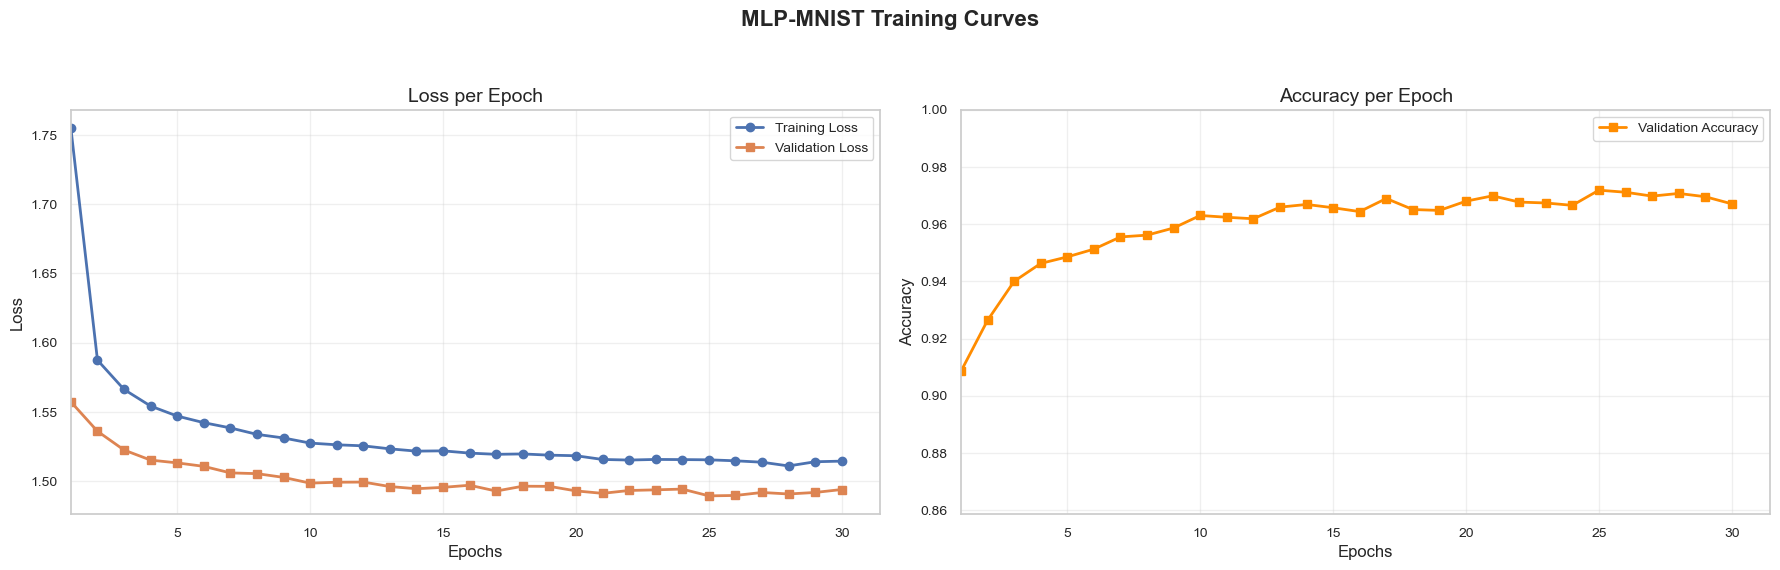

In [10]:

model = MultilayerPerceptron.from_defaults(
    dataset, 
    hidden_sizes=[128,64], 
    epochs=50, 
    lr=0.005, 
    batch_size=512, 
    early_stopping_delta=0.0001,
    wandb_logging=False,
    run_name ="MLP-MNIST",
)
model.train_once(val_percent=0.2, reset_weights=True)
model.plot_training_curves()

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [11]:
class ResidualMultiLayerPerceptron(MultilayerPerceptron):
    @staticmethod
    def generate(config):
        """
        Constructs a residual multilayer perceptron (MLP) model using the provided configuration dictionary.

        Args:
            config (dict): Dictionary containing model parameters. Expected keys are:
                - 'hidden_sizes' (list): List of layer sizes, including the input size as the first element.
                - 'shortcut_mappings' (dict): Dictionary mapping each layer index to the index of the layer to be used as its shortcut.
                - 'activations' (list): List of activation functions, one for each layer (hidden + output).
                - 'dropouts' (list): List of dropout rates, one for each layer (hidden + output).
                - 'flatten' (bool): Whether to flatten the input before feeding it to the network.
                - 'dataset' (torch.utils.data.Dataset): Dataset object (used to determine output dimension).

        Returns:
            nn.Sequential: A sequential container implementing the configured residual MLP model.
        """
        hidden_sizes = config['hidden_sizes']
        shortcut_mappings = config['shortcut_mappings']
        activations = config.get('activations', [nn.ReLU()] * (len(hidden_sizes) - 1) + [nn.Identity()])
        dropouts = config['dropouts']
        flatten = config['flatten']
        dataset = config['dataset']

        layers = []
        if flatten:
            layers.append(nn.Flatten())
        layers.append(LinearResidualNetwork(
            hidden_sizes,
            activations[:-1],
            dropouts[:-1],
            shortcut_mappings,
        ))
        last_dim = layers[-1].sizes[-1][-1]
        layers.append(PerceptronBlock(
            last_dim, len(dataset.classes),
            activation=activations[-1], dropout=dropouts[-1]
        ))
        return nn.Sequential(*layers)

    @classmethod
    def from_defaults(cls, dataset, hidden_sizes=[128], shortcut_mappings=None, **kwargs):
        """
        Initializes a ResidualMultiLayerPerceptron model with reasonable defaults and keyword overrides.

        Args:
            dataset (torch.utils.data.Dataset): The dataset to use.
            hidden_sizes (list, optional): List of hidden layer sizes, excluding the input size (input is inferred from data shape).
            shortcut_mappings (dict, optional): Dictionary mapping target layer indices to source indices for residual connections.
            device (str, optional): Device to use ('cuda' or 'cpu').
            epochs (int, optional): Number of training epochs.
            batch_size (int, optional): Batch size for training.
            lr (float, optional): Learning rate for optimizer.
            criterion (nn.Module, optional): Loss function.
            optimizer (Optimizer class, optional): Optimizer class to instantiate.
            early_stopping_patience (int, optional): Early stopping patience.
            early_stopping_delta (float, optional): Early stopping minimum delta.
            num_workers (int, optional): Number of workers for data loading.
            pin_memory (bool, optional): Whether to use pinned memory in DataLoader.
            persistent_workers (bool, optional): Whether to use persistent workers in DataLoader.
            scheduler (Scheduler class, optional): Learning rate scheduler class to instantiate.
            dropouts (list, optional): List of dropout rates for each layer.
            activations (list, optional): List of activation functions for each layer.
            flatten (bool, optional): Whether to flatten the input before the first layer.
            wandb_logging (bool, optional): Whether to enable Weights & Biases logging.
            project_name (str, optional): Name of the wandb project.
            run_name (str, optional): Name of the wandb run.

        Returns:
            ResidualMultiLayerPerceptron: An instantiated model wrapper, ready for training.
        """
        import torch
        import torch.nn as nn

        device = kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
        epochs = kwargs.get('epochs', 5)
        batch_size = kwargs.get('batch_size', 64)
        lr = kwargs.get('lr', 0.001)
        criterion = kwargs.get('criterion', nn.CrossEntropyLoss())
        optimizer_cls = kwargs.get('optimizer', torch.optim.Adam)
        early_stopping_patience = kwargs.get('early_stopping_patience', 5)
        early_stopping_delta = kwargs.get('early_stopping_delta', 0.01)
        num_workers = kwargs.get('num_workers', 4)
        pin_memory = kwargs.get('pin_memory', True)
        persistent_workers = kwargs.get('persistent_workers', True)
        scheduler_cls = kwargs.get('scheduler', None)

        data_shape = dataset.data.shape
        input_dim = data_shape[1] * data_shape[2]
        sizes = [input_dim] + hidden_sizes
        if shortcut_mappings is None:
            shortcut_mappings = {}

        dropouts = kwargs.get('dropouts', [0.1] * len(sizes))
        if not isinstance(dropouts, list) or len(dropouts) != len(sizes):
            dropouts = [0.1] * len(sizes)

        activations = kwargs.get('activations', [nn.ReLU()] * (len(sizes) - 1) + [nn.Identity()])
        if not isinstance(activations, list) or len(activations) != len(sizes):
            print('Warning: Activation functions mismatch. Using default ReLU for hidden layers and Identity for output layer')
            activations = [nn.ReLU()] * (len(sizes) - 1) + [nn.Identity()]
        flatten = kwargs.get('flatten', True)

        config = {
            'hidden_sizes': sizes,
            'shortcut_mappings': shortcut_mappings,
            'dropouts': dropouts,
            'activations': activations,
            'flatten': flatten,
            'dataset': dataset,
        }
        torch_model = cls.generate(config).to(device)
        optimizer = optimizer_cls(torch_model.parameters(), lr=lr)

        trainset, testset = torch.utils.data.random_split(
            dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
        )

        scheduler = None
        if scheduler_cls is not None:
            scheduler = scheduler_cls(optimizer, T_max=epochs, eta_min=0.0001)

        return ResidualMultiLayerPerceptron(
            model=torch_model,
            dataset=dataset,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            trainset=trainset,
            testset=testset,
            epochs=epochs,
            batch_size=batch_size,
            wandb_logging=kwargs.get('wandb_logging', True),
            project_name=kwargs.get('project_name', 'residual_mlp'),
            run_name=kwargs.get('run_name', 'ResidualMLP_Run'),
            early_stopping_patience=early_stopping_patience,
            early_stopping_delta=early_stopping_delta,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
            scheduler=scheduler
        )



class LinearResidualNetwork(nn.Module):
    """
    A class representing a linear network with shortcut connections.
    """

    def __init__(self, sizes, activations, dropouts, shortcut_mappings):
        """
        Initialize the LinearResidualNetwork.

        Args:
            sizes (list): List of layer sizes.
            activations (list): List of activation functions.
            dropouts (list): List of dropout rates.
            shortcut_mappings (dict): Dictionary mapping layer indices to shortcut connections.
        """
        super().__init__()
        self.sizes = sizes
        self.shortcut_mappings = {i: shortcut_mappings.get(i) for i in range(len(sizes) - 1)}


        # Iterates through the list of layer sizes to dynamically build a sequence of modules:
        # 1) Adds a fully connected (Linear) layer from sizes[i] to sizes[i+1].
        # 2) Adds a Dropout layer with the specified dropout rate for that layer.
        # 3) If a shortcut mapping exists at this index, adds a Linear layer to reshape the output to match the shortcut target size,
        #    then adds a ResidualSum module that sums the current layer’s output with the output from the shortcut layer, enabling residual connections.
        #       I use a ResidualSum module to have it appear in the model summary!
        # 4) Adds the specified activation function for this layer.
        # After building the modules, iterates over all child modules and collects their input and output feature sizes (when available)
        # into self.sizes as tuples, effectively recording the architecture’s layer dimensions for later use or reference.
        next_sizes_skip = None
        for i in range(len(sizes) - 1):
            input_size = sizes[i] if next_sizes_skip is None else sizes[next_sizes_skip]
            self.add_module(f'fc{i}', nn.Linear(input_size, sizes[i + 1]))
            self.add_module(f'dropout{i}', nn.Dropout(dropouts[i]))
            if self.shortcut_mappings[i] is not None:
                if sizes[i + 1] != sizes[self.shortcut_mappings[i]]:
                    self.add_module(f"reshape_in{i}", nn.Linear(sizes[i + 1], sizes[self.shortcut_mappings[i]]))
                else:
                    self.add_module(f"reshape_in{i}", nn.Identity())
                self.add_module(f'residual{i}', ResidualSum(sizes[self.shortcut_mappings[i]], f"fc{self.shortcut_mappings[i] - 1}" if self.shortcut_mappings[i] > 0 else 'flatten'))
                next_sizes_skip = self.shortcut_mappings[i]
            else:
                next_sizes_skip = None
            self.add_module(f'activation{i}', activations[i])

        self.sizes = []
        for child in self.children():
            in_size = child.in_features if hasattr(child, 'in_features') else None
            out_size = child.out_features if hasattr(child, 'out_features') else None
            if in_size is not None and out_size is not None:
                self.sizes.append((in_size, out_size))

        self.n_active_layers = len(sizes) - 1

    def forward(self, x):
        """
        Forward pass through the LinearResidualNetwork.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying linear transformations, activations, and residual connections.
        """
        outputs = {}

        # Iterates through the layers of the network, applying each layer's transformation to the input tensor x.
        # If a shortcut mapping exists for the current layer index, it stores the output of the current layer in outputs[i].
        # After applying the linear transformation, if a shortcut mapping exists for the current layer index,
        # it reshapes the output to match the size of the layer specified in the shortcut mapping.
        # Then, it applies the ResidualSum operation to add the reshaped output to the output of the layer specified in the shortcut mapping.
        if 0 in self.shortcut_mappings:
            outputs[0] = x
        for i in range(self.n_active_layers):
            # print(self.sizes[i])
            # print(f"shape of x in input to fc{i}: {x.shape}")            
            x = self.__getattr__(f'fc{i}')(x)
            x = self.__getattr__(f'dropout{i}')(x)
            if i+1 in self.shortcut_mappings.values():
                outputs[i+1] = x
            # print(f"shape of x after fc{i}: {x.shape}")
            if self.shortcut_mappings[i] is not None:
                x = self.__getattr__(f"reshape_in{i}")(x)
                # print(f"shape of x after reshape_in{i}: {x.shape}")
                # print(f"shape of outputs[{self.shortcut_mappings[i]}] before residual: {outputs[self.shortcut_mappings[i]].shape}")
                x = self.__getattr__(f'residual{i}')(x, outputs[self.shortcut_mappings[i]])
                # print(f"shape of x after residual: {x.shape}")
            x = self.__getattr__(f'activation{i}')(x)
        return x


class ResidualSum(nn.Module):
    """
    A class representing a residual sum operation.
    """

    def __init__(self, num_features, skip_index):
        """
        Initialize the ResidualSum.

        Args:
            num_features (int): Number of features.
            skip_index (str): Name representing the layer to skip from.
        """
        super().__init__()
        self.num_features = num_features
        self.skip_index = skip_index
        self.identity = nn.Identity()

    def forward(self, x, residual):
        """
        Forward pass through the ResidualSum.

        Args:
            x (torch.Tensor): Input tensor.
            residual (torch.Tensor): Residual tensor to be added.

        Returns:
            torch.Tensor: Output tensor after adding the residual.
        """
        return x + self.identity(residual)

    def __repr__(self):
        return f"ResidualSum(num_features={self.num_features}, residual_from={self.skip_index})"

c:\Users\Admin\anaconda3\envs\DLA\Lib\site-packages\torch\utils\data\_utils\pin_memory.py:21: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at C:\bld\libtorch_1741563143560\work\aten\src\ATen\ParallelNative.cpp:228.)
  torch.set_num_threads(1)


Epoch 0 | Loss: 2.2861 | Val Loss: 2.2555 | Val Acc: 0.4219
Epoch 1 | Loss: 2.1907 | Val Loss: 2.1038 | Val Acc: 0.5531
Epoch 2 | Loss: 2.0374 | Val Loss: 1.9496 | Val Acc: 0.6619
Epoch 3 | Loss: 1.9201 | Val Loss: 1.8394 | Val Acc: 0.7577
Epoch 4 | Loss: 1.8442 | Val Loss: 1.7713 | Val Acc: 0.7906
Epoch 5 | Loss: 1.7990 | Val Loss: 1.7313 | Val Acc: 0.8054
Epoch 6 | Loss: 1.7744 | Val Loss: 1.7055 | Val Acc: 0.8135
Epoch 7 | Loss: 1.7532 | Val Loss: 1.6879 | Val Acc: 0.8200
Epoch 8 | Loss: 1.7400 | Val Loss: 1.6756 | Val Acc: 0.8237
Epoch 9 | Loss: 1.7295 | Val Loss: 1.6657 | Val Acc: 0.8252
Epoch 10 | Loss: 1.7197 | Val Loss: 1.6561 | Val Acc: 0.8285
Epoch 11 | Loss: 1.7059 | Val Loss: 1.6330 | Val Acc: 0.8702
Epoch 12 | Loss: 1.6841 | Val Loss: 1.6143 | Val Acc: 0.8852
Epoch 13 | Loss: 1.6689 | Val Loss: 1.6027 | Val Acc: 0.8900
Epoch 14 | Loss: 1.6592 | Val Loss: 1.5945 | Val Acc: 0.8942
Epoch 15 | Loss: 1.6522 | Val Loss: 1.5878 | Val Acc: 0.8990
Epoch 16 | Loss: 1.6455 | Val Loss

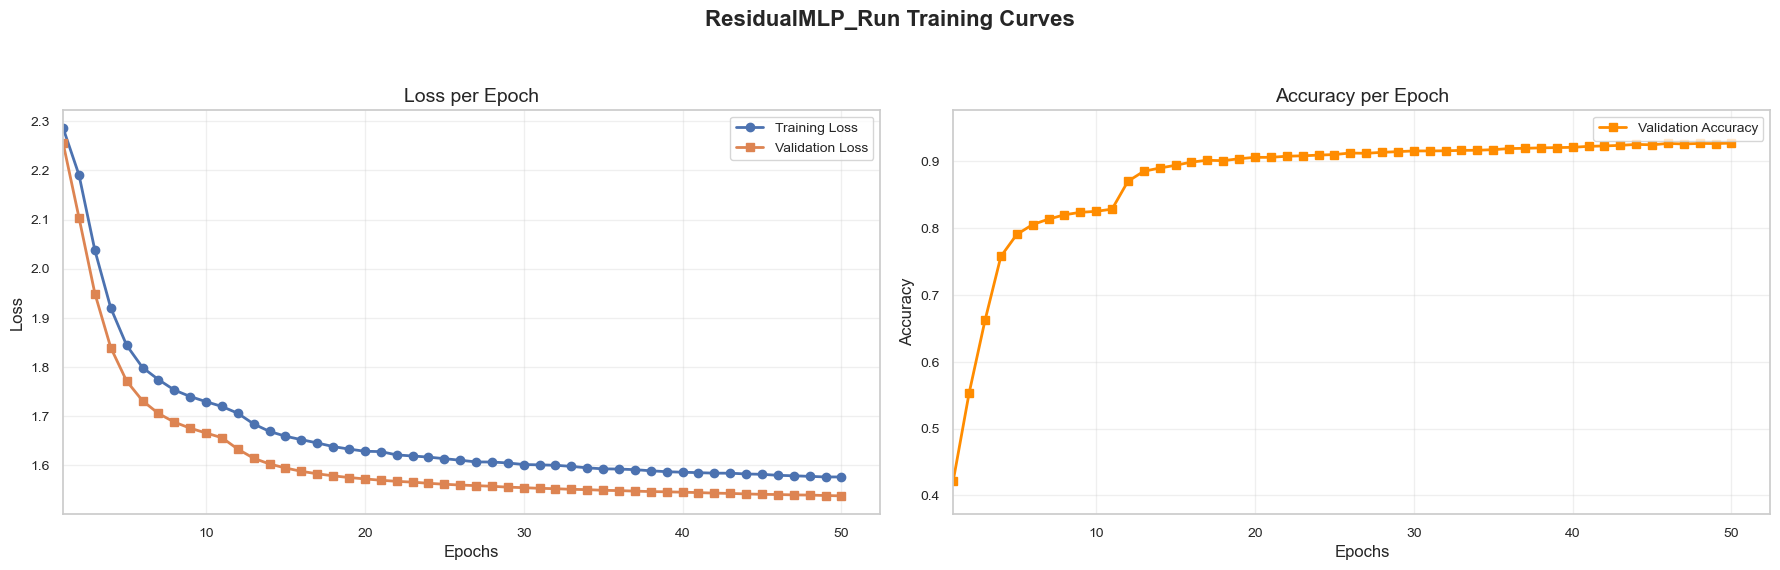

In [12]:
dataset = datasets.MNIST(root='dataset/', transform=transforms.ToTensor(), download=True)
residualMLP = ResidualMultiLayerPerceptron.from_defaults(
    dataset, 
    hidden_sizes=[128,64], 
    shortcut_mappings = {1:1}, 
    epochs=50, 
    lr=0.00005, 
    batch_size=512,
    early_stopping_delta=0.001, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True,
    wandb_logging=False,
)
residualMLP.train_once(val_percent=0.1, reset_weights=True)
residualMLP.plot_training_curves()

##### MLP vs Residual MLP: The "How Not to Kill Your Gradients" Showdown

Here’s a quick behind-the-scenes look at an experiment that pits your everyday Multilayer Perceptron (MLP) against its cousin: the Residual MLP. The game? Train networks with more and more layers and see who handles deeper waters better.

**What actually happens?**
- As we stack more layers, the classic MLP starts to choke a bit: training becomes slower, validation accuracy doesn't quite keep up with the residual version.
- Meanwhile, the Residual MLP just keeps cruising—validation accuracy keeps climbing, and the network doesn't lose its way (or its gradients).

**But why? (Look at the rightmost plot!)**
- The trick is all in the gradients.
- The third plot tracks the *median gradient* of the **last layer** for both models during training (averaged accross 5 runs).
- For regular MLPs, the gradients shrink to oblivion (classic vanishing gradient issue), especially as the network gets deeper.
- Residual MLPs, thanks to their skip connections, keep gradients alive and kicking even in the last layers.




In [13]:
# This section will address if and why a skip connection is effective in a residual MLP.

def test_skip_connection_effectiveness(id="alpha"):
    """
    Test the effectiveness of skip connections in a Residual MLP by comparing its performance
    with and without skip connections on the MNIST dataset. 
    The test will train two models: one with skip connections and one without, and then compare their validation accuracies.
    To achieve the same number of layers in both models, the model without skip connections will have one additional layer for each reshape operation.: 
    this is because the skip connection model has one extra layer for each reshape operation.
    By testing for k from 1 to 3, we are effectively testing for 
    1:2 layers, 2:4 layers, 3:6 layers. 
    """
    k = [1, 2, 3]
    for k_iter in k:
        print(f"Testing with {k_iter} hidden layers...")

        min_hid = 0 if k_iter == 1 else 1
        shortcut_mappings = {i: i for i in range(min_hid, k_iter)}
        residual_mlp = ResidualMultiLayerPerceptron.from_defaults(
            dataset, hidden_sizes=[int(512 * 2**-j) for j in range(k_iter)], shortcut_mappings=shortcut_mappings,
            epochs=30, lr=0.00005, batch_size=64, early_stopping_delta=0.001, num_workers=4, pin_memory=True, persistent_workers=True
        )
        print(f"Training residual MLP:")
        print(residual_mlp)
        print(f"Number of parameters: {sum(p.numel() for p in residual_mlp.model.parameters() if p.requires_grad)}")
        residual_mlp.set_project_name(f"skip_effectiveness")
        residual_mlp.set_run_name(f'residual_mlp_{k_iter}_layers_{id}')
        residual_mlp.train_once(val_percent=0.1, reset_weights=True)

        mlp = MultilayerPerceptron.from_defaults(
            dataset, hidden_sizes=[int(512 * 2**-j) for j in range(2*k_iter)], epochs=30, lr=0.00005, batch_size=64,
            early_stopping_delta=0.001, num_workers=4, pin_memory=True, early_stopping_patience=10
        )
        print(f"Training MLP without skip connections:")
        print(mlp)
        print(f"Number of parameters: {sum(p.numel() for p in mlp.model.parameters() if p.requires_grad)}")
        mlp.set_project_name(f"skip_effectiveness")
        mlp.set_run_name(f'mlp_{k_iter}_layers_{id}')
        mlp.train_once(val_percent=0.1, reset_weights=True)  
   

 NOTE: This section requires my wandb API key to run, so it is commented out.
The results are available in the README.md file.

Running test for suffix: alpha
Running test for suffix: bravo
Running test for suffix: charlie
Running test for suffix: delta
Running test for suffix: echo


C:\Users\Admin\AppData\Local\Temp\ipykernel_24480\2330923748.py:164: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.04, 1, 0.96])


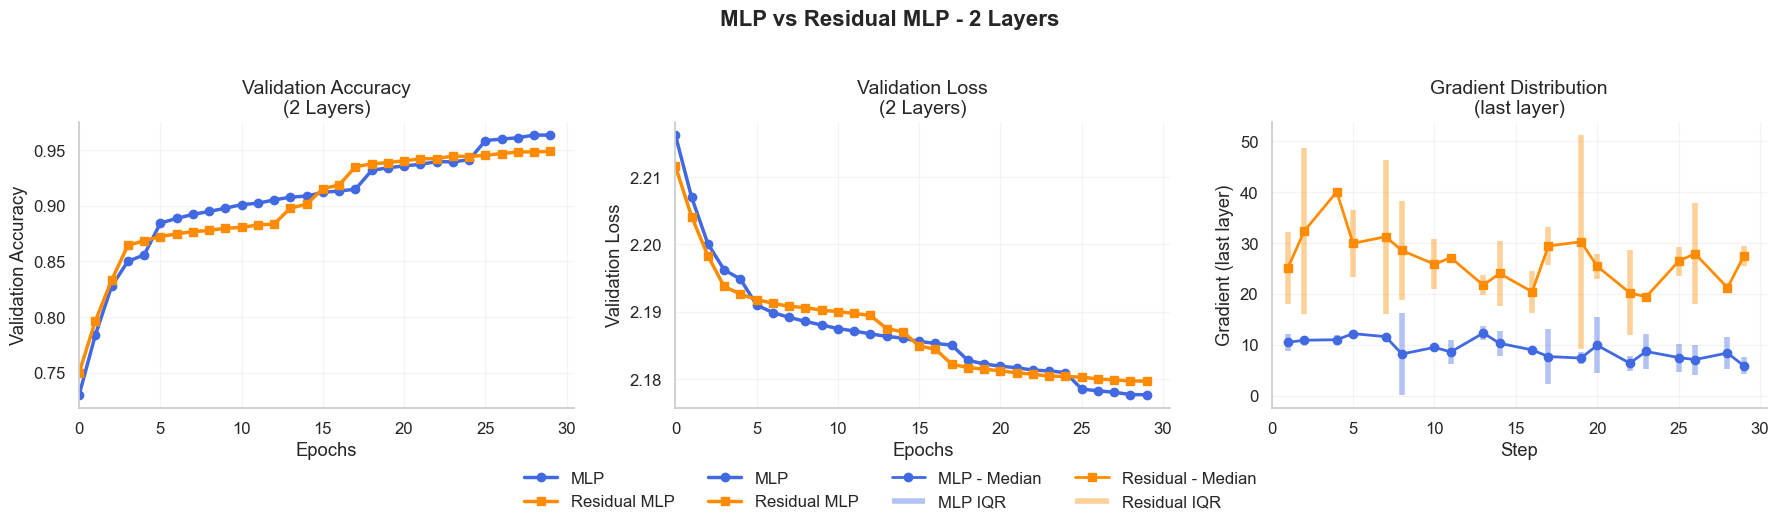

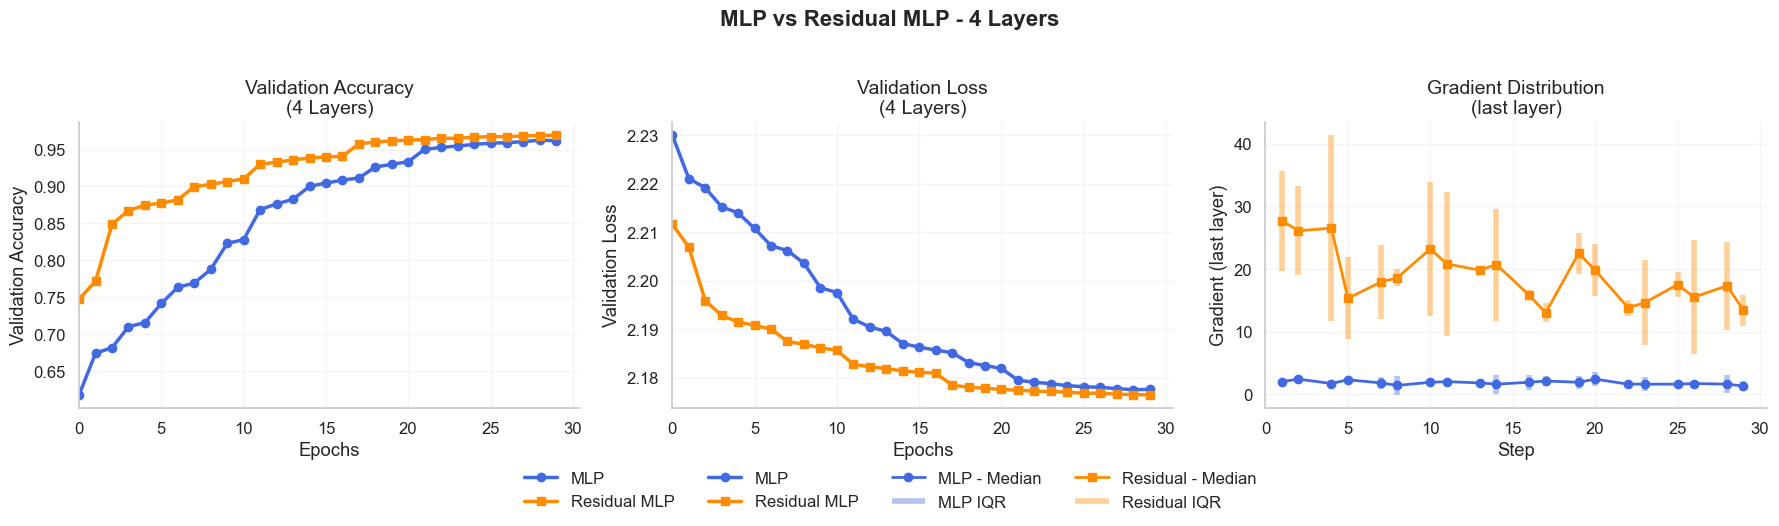

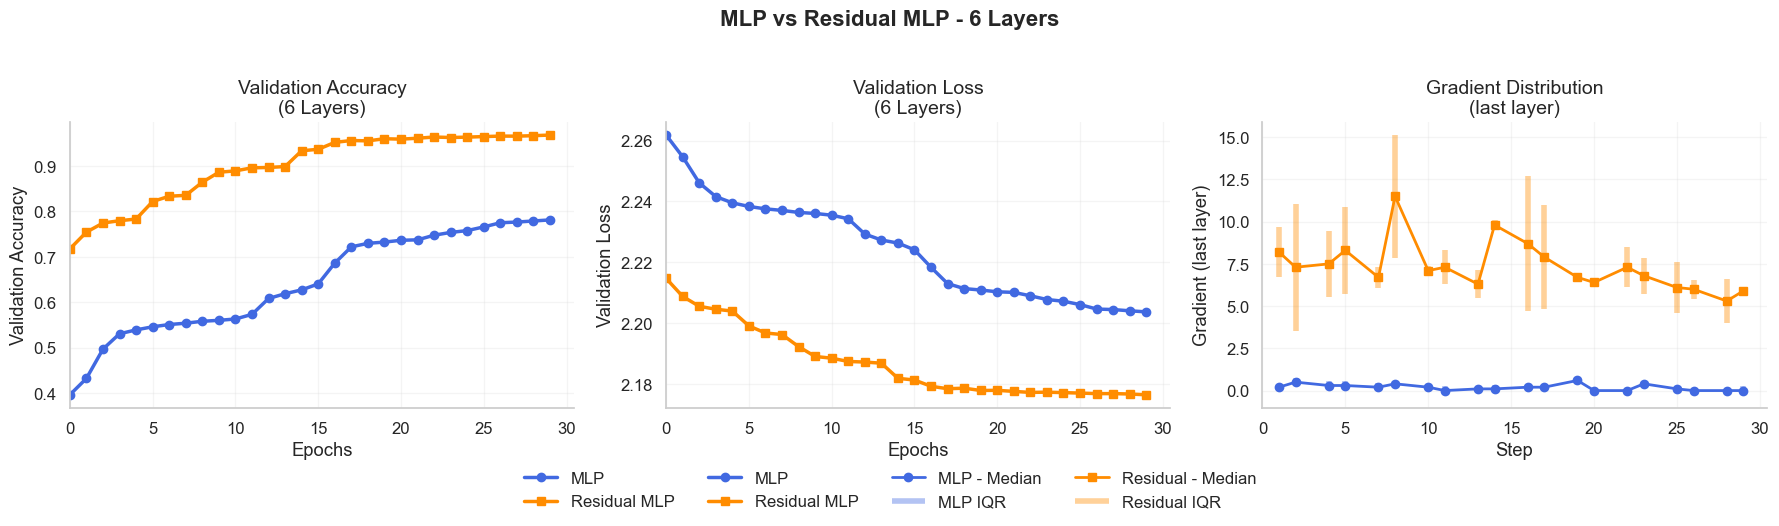

In [ ]:
# import wandb
# import numpy as np


# run_suffixes = ["alpha", "bravo", "charlie", "delta", "echo"]
# for suffix in run_suffixes:
#     print(f"Running test for suffix: {suffix}")
#     # test_skip_connection_effectiveness(id=suffix)

# project_name = "skip_effectiveness"
# runs = wandb.Api().runs(project_name)
# mlp_runs = [run for run in runs if run.name.startswith('mlp_')]
# residual_mlp_runs = [run for run in runs if run.name.startswith('residual_mlp_')]
# def get_max_graph_key(row):
#     max_id = -1
#     max_key = None
#     for key in row.keys():
#         if key.startswith("gradients/") and key.endswith(".fc.weight"):
#             try:
#                 idx = int(key.split("graph_")[1].split(".")[0])
#                 if idx > max_id:
#                     max_id = idx
#                     max_key = key
#             except Exception:
#                 continue
#     return max_key

# def expand_histogram(bins, counts):
#     values = []
#     for left, right, count in zip(bins[:-1], bins[1:], counts):
#         values.extend([0.5 * (left + right)] * int(count))
#     return values

# def extract_gradient_medians_per_step(run):
#     medians_per_step = []
#     iqr_per_step = []
#     steps = []
#     for row in run.scan_history():
#         key = get_max_graph_key(row)
#         if key and key in row and isinstance(row[key], dict):
#             grad_dict = row[key]
#             if 'values' not in grad_dict:
#                 continue
#             values = grad_dict['values']
#             if not values or len(values) == 0:
#                 continue
#             values = np.array(values)   
#             medians_per_step.append(np.median(values))
#             iqr_per_step.append(np.percentile(values, [25, 75]))
#             steps.append(row.get("_step", len(medians_per_step)-1))
#     return steps, medians_per_step, iqr_per_step


# def aggregate_across_runs(runs):
#     all_medians = dict()
#     all_iqrs = dict()
#     for run in runs:
#         steps, medians, iqrs = extract_gradient_medians_per_step(run)

#         for s, m, i in zip(steps, medians, iqrs):
#             all_medians.setdefault(s, []).append(m)
#             all_iqrs.setdefault(s, []).append(i)
#     sorted_steps = sorted(all_medians.keys())
#     medians_arr = np.array([all_medians[s] for s in sorted_steps])
#     iqr_arr = np.array([all_iqrs[s] for s in sorted_steps])
#     return np.array(sorted_steps), medians_arr, iqr_arr



# mlp_runs_mappings = {layers: [run for run in mlp_runs if str(layers) in run.name] for layers in (1,2,3) if f"{layers}"}
# residual_mlp_runs_mappings = {layers: [run for run in residual_mlp_runs if str(layers) in run.name] for layers in (1,2,3) if f"{layers}"}

# for layers in (1, 2, 3):
#     mlp_run = mlp_runs_mappings.get(layers, [])
#     residual_mlp_run = residual_mlp_runs_mappings.get(layers, [])
    
#     if not mlp_run or not residual_mlp_run:
#         print(f"No runs found for {layers} layers.")
#         continue

#     mlp_histories = [run.history(keys=["val_acc", "val_loss"]) for run in mlp_run]
#     residual_mlp_histories = [run.history(keys=["val_acc", "val_loss"]) for run in residual_mlp_run]

#     mlp_val_acc = [history["val_acc"] for history in mlp_histories]
#     mlp_val_loss = [history["val_loss"] for history in mlp_histories]
#     residual_mlp_val_acc = [history["val_acc"] for history in residual_mlp_histories]
#     residual_mlp_val_loss = [history["val_loss"] for history in residual_mlp_histories]


#     mlp_gradient_last_layer_steps, mlp_gradient_last_layer_medians, mlp_gradient_last_layer_iqrs = aggregate_across_runs(mlp_run)
#     res_gradient_last_layer_steps, res_gradient_last_layer_medians, res_gradient_last_layer_iqrs = aggregate_across_runs(residual_mlp_run)
#     if mlp_gradient_last_layer_medians.ndim == 1:
#         mlp_gradient_last_layer_medians = mlp_gradient_last_layer_medians[:, None]
#     if res_gradient_last_layer_medians.ndim == 1:
#         res_gradient_last_layer_medians = res_gradient_last_layer_medians[:, None]


#     import numpy as np
#     mlp_avg_val_acc = np.stack([np.array(acc) for acc in mlp_val_acc]).mean(axis=0)
#     mlp_avg_val_loss = np.stack([np.array(loss) for loss in mlp_val_loss]).mean(axis=0)

#     residual_mlp_avg_val_acc = np.stack([np.array(acc) for acc in residual_mlp_val_acc]).mean(axis=0)
#     residual_mlp_avg_val_loss = np.stack([np.array(loss) for loss in residual_mlp_val_loss]).mean(axis=0)

#     mlp_median = np.mean(mlp_gradient_last_layer_medians, axis=1)
#     mlp_iqr = np.mean(mlp_gradient_last_layer_iqrs[:, 1] - mlp_gradient_last_layer_iqrs[:, 0], axis=1)
#     mlp_iqr25 = mlp_median - 0.5 * mlp_iqr
#     mlp_iqr75 = mlp_median + 0.5 * mlp_iqr

#     res_median = np.mean(res_gradient_last_layer_medians, axis=1)
#     res_iqr = np.mean(res_gradient_last_layer_iqrs[:, 1] - res_gradient_last_layer_iqrs[:, 0], axis=1)
#     res_iqr25 = res_median - 0.5 * res_iqr
#     res_iqr75 = res_median + 0.5 * res_iqr

#     import matplotlib.pyplot as plt
#     try:
#         import seaborn as sns
#     except ImportError:
#         print("Seaborn is not installed. Installing it now...")
#         !pip install seaborn
#         import seaborn as sns

#     sns.set_theme(context='notebook', style='whitegrid', font_scale=1.1)

#     fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

#     axs[0].plot(mlp_avg_val_acc, label='MLP', color='royalblue', linewidth=2.5, marker='o')
#     axs[0].plot(residual_mlp_avg_val_acc, label='Residual MLP', color='darkorange', linewidth=2.5, marker='s')
#     axs[0].set_xlabel('Epochs')
#     axs[0].set_ylabel('Validation Accuracy')
#     axs[0].set_title(f'Validation Accuracy\n({layers*2} Layers)', fontsize=14)
#     axs[0].grid(alpha=0.2)
    
#     axs[1].plot(mlp_avg_val_loss, label='MLP', color='royalblue', linewidth=2.5, marker='o')
#     axs[1].plot(residual_mlp_avg_val_loss, label='Residual MLP', color='darkorange', linewidth=2.5, marker='s')
#     axs[1].set_xlabel('Epochs')
#     axs[1].set_ylabel('Validation Loss')
#     axs[1].set_title(f'Validation Loss\n({layers*2} Layers)', fontsize=14)
#     axs[1].grid(alpha=0.2)

#     axs[2].plot(mlp_gradient_last_layer_steps, mlp_median, 'o-', label='MLP - Median', color='royalblue', linewidth=2)
#     axs[2].vlines(mlp_gradient_last_layer_steps, mlp_iqr25, mlp_iqr75, color='royalblue', lw=4, alpha=0.4, label='MLP IQR')
#     axs[2].plot(res_gradient_last_layer_steps, res_median, 's-', label='Residual - Median', color='darkorange', linewidth=2)
#     axs[2].vlines(res_gradient_last_layer_steps, res_iqr25, res_iqr75, color='darkorange', lw=4, alpha=0.4, label='Residual IQR')
#     axs[2].set_xlabel('Step')
#     axs[2].set_ylabel('Gradient (last layer)')
#     axs[2].set_title('Gradient Distribution\n(last layer)', fontsize=14)
#     axs[2].grid(alpha=0.2)

#     handles, labels_ = [], []
#     for ax in axs:
#         h, l = ax.get_legend_handles_labels()
#         handles.extend(h)
#         labels_.extend(l)
#     fig.legend(handles, labels_, loc='lower center', ncol=4, frameon=False, fontsize=12, bbox_to_anchor=(0.5, -0.05))

#     for ax in axs:
#         ax.tick_params(axis='both', which='major', labelsize=12)
#         ax.set_xlim(left=0)
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)

#     plt.suptitle(f"MLP vs Residual MLP - {layers*2} Layers", fontsize=16, fontweight='bold')
#     plt.tight_layout(rect=[0, 0.04, 1, 0.96])
#     plt.show()



### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [15]:

class LayerConfiguration:
    """
    A base class for specifying a layer configuration. This is intended to be subclassed
    for different types of layers (e.g., convolutional, pooling).
    """
    def __init__(self, layer_type):
        self.layer_type = layer_type
    
    
    def create_layer(self):
        """
        Create the layer. This method should be implemented in each subclass.
        """
        raise NotImplementedError("This method should be overridden by subclasses")
    
    def __repr__(self):
        """
        String representation of the layer configuration.
        """
        return f"{self.__class__.__name__}(layer_type={self.layer_type})"
   
class ConvLayerConfiguration(LayerConfiguration):
    """
    A subclass of LayerConfiguration for convolutional layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                 activation=nn.ReLU(), dropout=0.1, batch_norm=False):
        """
        Initialize a convolutional layer configuration.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int or tuple): Size of the convolving kernel.
            stride (int or tuple): Stride of the convolution.
            padding (int or tuple): Zero-padding added to both sides of the input.
            activation (torch.nn.Module): Activation function.
            dropout (float): Dropout rate.
            batch_norm (bool): Whether to apply batch normalization after the convolution.
        """
        super().__init__('conv')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.dropout = dropout
        self.batch_norm = batch_norm

    def create_layer(self):
        """
        Create a convolutional block.
        """
        return ConvolutionBlock(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            activation=self.activation,
            dropout=self.dropout,
            batch_norm=self.batch_norm
        )

class PoolLayerConfiguration(LayerConfiguration):
    """
    A subclass of LayerConfiguration for pooling layers (e.g., max pooling, avg pooling).
    """

    def __init__(self, pool_type, kernel_size, stride=None, padding=0):
        """
        Initialize a pooling layer configuration.

        Args:
            pool_type (str): The type of the pool. Options: 'max' or 'avg'.
            kernel_size (int or tuple): Size of the pooling kernel.
            stride (int or tuple): Stride of the pooling. Default is kernel_size.
            padding (int or tuple): Padding for the pooling. Default is 0.
        """
        super().__init__('pool')
        self.pool_type = pool_type
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size
        self.padding = padding

    def create_layer(self):
        """
        Create the pooling layer.
        """
        if self.pool_type == 'max':
            return nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        elif self.pool_type == 'avg':
            return nn.AvgPool2d(kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        else:
            raise ValueError(f"Unknown pool_type: {self.pool_type}")

class ConvolutionalNeuralNetwork(DLModel):
    """
    Wrapper for a flexible convolutional neural network (CNN) model, supporting custom layer configurations.
    """

    @staticmethod
    def generate(config):
        """
        Builds a CNN model as a torch Sequential module using the provided configuration dictionary.

        Args:
            config (dict): Model configuration dictionary with the following keys:
                - 'layers_config' (list): List of LayerConfiguration objects, each providing a .create_layer() method.
                - 'num_features' (int): Number of features for the final linear layer (typically from last conv out_channels).
                - 'data_classes' (int): Number of output classes.
        
        Returns:
            nn.Sequential: Sequential CNN model ready for training.
        """
        layers_config = config['layers_config']
        num_features = config['num_features']
        data_classes = config['data_classes']

        layers = [layer_conf.create_layer() for layer_conf in layers_config]
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(num_features, data_classes))
        layers.append(nn.Softmax(dim=1))
        return nn.Sequential(*layers)

    @classmethod
    def from_defaults(cls, dataset, layers_config, device=None, **kwargs):
        """
        Instantiates a ConvolutionalNeuralNetwork model with provided layer configuration and standard training options.

        Args:
            dataset (torch.utils.data.Dataset): Dataset object with .data and .classes.
            layers_config (list): List of LayerConfiguration objects, each with .create_layer() and (if conv) .out_channels.
            device (str, optional): Device string, e.g. 'cuda' or 'cpu'.
            epochs (int, optional): Number of training epochs.
            batch_size (int, optional): Batch size.
            lr (float, optional): Learning rate.
            criterion (nn.Module, optional): Loss function.
            optimizer (Optimizer class, optional): Optimizer class to instantiate.
            early_stopping_patience (int, optional): Early stopping patience.
            early_stopping_delta (float, optional): Early stopping minimum delta.
            num_workers (int, optional): DataLoader worker processes.
            pin_memory (bool, optional): DataLoader pinned memory.
            persistent_workers (bool, optional): DataLoader persistent workers.
            scheduler (Scheduler class, optional): Learning rate scheduler class.
            wandb_logging (bool, optional): Enable wandb logging.
            project_name (str, optional): wandb project name.

        Returns:
            ConvolutionalNeuralNetwork: Model wrapper instance ready for training.
        """
        import torch
        import torch.nn as nn

        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        data_shape = dataset.data.shape
        in_channels = data_shape[3] if len(data_shape) == 4 else 1
        if layers_config and hasattr(layers_config[0], "in_channels"):
            layers_config[0].in_channels = in_channels

        for conf in reversed(layers_config):
            if hasattr(conf, "out_channels"):
                num_features = conf.out_channels
                break
        else:
            raise ValueError("At least one convolutional layer with 'out_channels' is required.")

        data_classes = len(dataset.classes)
        config = {
            'layers_config': layers_config,
            'num_features': num_features,
            'data_classes': data_classes,
        }

        torch_model = cls.generate(config).to(device)
        optimizer_cls = kwargs.get('optimizer', torch.optim.Adam)
        lr = kwargs.get('lr', 0.001)
        optimizer_instance = optimizer_cls(torch_model.parameters(), lr=lr)
        criterion = kwargs.get('criterion', nn.CrossEntropyLoss())
        epochs = kwargs.get('epochs', 5)
        batch_size = kwargs.get('batch_size', 64)

        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

        scheduler_cls = kwargs.get('scheduler', None)
        scheduler = scheduler_cls(optimizer_instance, T_max=epochs, eta_min=0.0001) if scheduler_cls else None

        return ConvolutionalNeuralNetwork(
            model=torch_model,
            dataset=dataset,
            optimizer=optimizer_instance,
            criterion=criterion,
            device=device,
            trainset=trainset,
            testset=testset,
            epochs=epochs,
            batch_size=batch_size,
            wandb_logging=kwargs.get('wandb_logging', True),
            project_name=kwargs.get('project_name', 'cnn'),
            early_stopping_patience=kwargs.get('early_stopping_patience', 5),
            early_stopping_delta=kwargs.get('early_stopping_delta', 0.01),
            num_workers=kwargs.get('num_workers', 4),
            pin_memory=kwargs.get('pin_memory', True),
            persistent_workers=kwargs.get('persistent_workers', True),
            scheduler=scheduler
        )


class ConvolutionBlock(nn.Module):
    """
    A class representing a single convolutional block in a CNN.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                 activation=nn.ReLU(), dropout=0.1, batch_norm=False):
        """
        Initialize the ConvolutionBlock.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int or tuple): Size of the convolving kernel.
            stride (int or tuple): Stride of the convolution.
            padding (int or tuple): Zero-padding added to both sides of the input.
            activation (torch.nn.Module): Activation function.
            dropout (float): Dropout rate.
            batch_norm (bool): Whether to apply batch normalization after the convolution.
        """
        super(ConvolutionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.activation = activation       
        self.dropout = nn.Dropout2d(dropout)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None   
        if batch_norm:
            self.conv = nn.Sequential(self.conv, self.batch_norm)

        self.__out_channels = out_channels
        self.__in_channels = in_channels
        

    def forward(self, x):
        """
        Forward pass through the ConvolutionBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying convolution, activation, and dropout.
        """       
        x = self.conv(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x
    
    def remove_activation(self):
        """
        Remove the activation function from the block.
        """
        self.activation = nn.Identity()
    
    @property
    def out_channels(self):
        return self.conv.out_channels if hasattr(self.conv, 'out_channels') else self.__out_channels
    
    @property
    def in_channels(self):
        return self.conv.in_channels if hasattr(self.conv, 'in_channels') else self.__in_channels
    


In [ ]:
cifar = datasets.CIFAR10(root='dataset/', transform=transforms.ToTensor(), download=True)
conv_layers = [
    ConvLayerConfiguration(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
    ConvLayerConfiguration(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    PoolLayerConfiguration(pool_type='max', kernel_size=2, stride=2),
    ConvLayerConfiguration(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    PoolLayerConfiguration(pool_type='max', kernel_size=2, stride=3),
    ConvLayerConfiguration(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
]
conv_model = ConvolutionalNeuralNetwork.from_defaults(
    cifar, 
    layers_config=conv_layers, 
    epochs=50, 
    lr=0.0005, 
    batch_size=256,
    wandb_logging=False,
)
conv_model.train_once(val_percent=0.1)

Epoch 0 | Loss: 2.2341 | Val Loss: 2.1922 | Val Acc: 0.2622
Epoch 1 | Loss: 2.1788 | Val Loss: 2.1457 | Val Acc: 0.3060
Epoch 2 | Loss: 2.1429 | Val Loss: 2.1157 | Val Acc: 0.3387
Epoch 3 | Loss: 2.1179 | Val Loss: 2.1001 | Val Acc: 0.3518
Epoch 4 | Loss: 2.1039 | Val Loss: 2.0792 | Val Acc: 0.3745
Epoch 5 | Loss: 2.0847 | Val Loss: 2.0614 | Val Acc: 0.3935
Epoch 6 | Loss: 2.0679 | Val Loss: 2.0539 | Val Acc: 0.3997
Epoch 7 | Loss: 2.0529 | Val Loss: 2.0320 | Val Acc: 0.4238
Epoch 8 | Loss: 2.0373 | Val Loss: 2.0233 | Val Acc: 0.4303
Epoch 9 | Loss: 2.0256 | Val Loss: 2.0119 | Val Acc: 0.4430
Epoch 10 | Loss: 2.0147 | Val Loss: 1.9953 | Val Acc: 0.4680
Epoch 11 | Loss: 2.0049 | Val Loss: 2.0129 | Val Acc: 0.4385
Epoch 12 | Loss: 1.9936 | Val Loss: 1.9794 | Val Acc: 0.4785
Epoch 13 | Loss: 1.9845 | Val Loss: 1.9731 | Val Acc: 0.4898
Epoch 14 | Loss: 1.9747 | Val Loss: 1.9627 | Val Acc: 0.4988
Epoch 15 | Loss: 1.9658 | Val Loss: 1.9594 | Val Acc: 0.5015
Epoch 16 | Loss: 1.9553 | Val Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class ProjectionBlock(nn.Conv2d):
    def __repr__(self):
        return (f"ProjectionBlock(in_channels={self.in_channels}, out_channels={self.out_channels}, "
                f"kernel_size={self.kernel_size}, stride={self.stride}, padding={self.padding})")
    

# Residual Block configuration (for convolutional blocks)
class ResBlockLayerConfiguration(LayerConfiguration):
    """
    Layer configuration for a residual block composed of one or more convolutional sub-blocks.
    The shortcut_mappings dictionary maps sub-layer indices to the index from which to take the residual.
    e.g., {1:0} adds output of sub-layer 0 into sub-layer 1.
    """
    def __init__(self, conv_configs, shortcut_mappings):
        super().__init__('res')
        self.conv_configs = conv_configs
        self.shortcut_mappings = shortcut_mappings

    def create_layer(self):
        conv_layers = [conf.create_layer() for conf in self.conv_configs]
        return ResidualConvBlock(conv_layers, self.shortcut_mappings)
    


class ResidualConvBlock(nn.Module):
    """
    Applies a sequence of conv blocks with residual connections.
    If source and dest channels differ, uses ProjectionBlock for 1x1 conv.
    """
    def __init__(self, conv_layers, shortcut_mappings, activations=None):
        super().__init__()
        self.conv_layers = nn.ModuleList(conv_layers)
        self.shortcut_mappings = shortcut_mappings
        self.activations = activations or {i: nn.ReLU() for i in range(len(conv_layers))}
        # Build projection modules
        self.projections = nn.ModuleDict()
        for dst, src in shortcut_mappings.items():
            c_src = conv_layers[src].out_channels
            c_dst = conv_layers[dst].out_channels
            if c_src != c_dst:
                self.projections[str(dst)] = ProjectionBlock(c_dst, c_src, kernel_size=1, stride=1, padding=0)
            else:
                self.projections[str(dst)] = nn.Identity()
        
        # Build residual sum modules
        self.residuals = nn.ModuleDict()
        for dst, src in shortcut_mappings.items():
            c_src = conv_layers[src].out_channels
            self.residuals[str(dst)] = ResidualSum(c_src, f"output_of({src})")

        self.out_channels = conv_layers[-1].out_channels if shortcut_mappings[len(conv_layers) - 1] is not None else conv_layers[shortcut_mappings[len(conv_layers) - 1]].out_channels


    def forward(self, x):
        outputs = {}
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            # Save source outputs
            if i in self.shortcut_mappings.values():
                outputs[i] = x
            # Apply projection if configured
            key = str(i)
            proj = self.projections[key] if key in self.projections else None
            if proj is not None:
                x = proj(x)
            # Add residual if configured
            if key in self.residuals:
                res = outputs[self.shortcut_mappings[i]]
                x = self.residuals[key](x, res)
            # Activation
            act = self.activations.get(i)
            if act:
                x = act(x)
        return x

    def __repr__(self):
        lines = []
        for idx, layer in enumerate(self.conv_layers):
            lines.append(f"  ({idx}): {layer}")
            key = str(idx)
            if key in self.projections and not isinstance(self.projections[key], nn.Identity):
                lines.append(f"  proj_{idx}: {self.projections[key]}")
            if key in self.residuals:
                lines.append(f"  sum_{idx}: {self.residuals[key]}")
            act = self.activations.get(idx)
            if act:
                lines.append(f"  act_{idx}: {act}")
        return f"{self.__class__.__name__}(\n" + "\n".join(lines) + "\n)"

class ResConvolutionalNeuralNetwork(DLModel):
    """
    Wrapper for a configurable residual convolutional neural network (Res-CNN), supporting custom layer configurations.
    """

    @staticmethod
    def generate(config):
        """
        Builds a residual CNN model as a torch Sequential module using the provided configuration.

        Args:
            config (dict): Model configuration dictionary with the following keys:
                - 'layers_config' (list): List of LayerConfiguration objects, each providing a .create_layer() method.
                - 'final_in_channels' (int): Number of input channels for the final linear layer.
                - 'data_classes' (int): Number of output classes.

        Returns:
            nn.Sequential: Sequential Res-CNN model ready for training.
        """
        layers_config = config['layers_config']
        final_in_channels = config['final_in_channels']
        data_classes = config['data_classes']

        layers = [conf.create_layer() for conf in layers_config]
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(final_in_channels, data_classes))
        return nn.Sequential(*layers)

    @classmethod
    def from_defaults(cls, dataset, layers_config, device=None, **kwargs):
        """
        Instantiates a ResConvolutionalNeuralNetwork with provided layer configuration and standard training options.

        Args:
            dataset (torch.utils.data.Dataset): Dataset object with .data and .classes.
            layers_config (list): List of LayerConfiguration objects.
            device (str, optional): Device string, e.g. 'cuda' or 'cpu'.
            epochs (int, optional): Number of training epochs.
            batch_size (int, optional): Batch size.
            lr (float, optional): Learning rate.
            criterion (nn.Module, optional): Loss function.
            optimizer (Optimizer class, optional): Optimizer class to instantiate.
            early_stopping_patience (int, optional): Early stopping patience.
            early_stopping_delta (float, optional): Early stopping minimum delta.
            num_workers (int, optional): DataLoader worker processes.
            pin_memory (bool, optional): DataLoader pinned memory.
            persistent_workers (bool, optional): DataLoader persistent workers.
            scheduler (Scheduler class, optional): Learning rate scheduler class.
            wandb_logging (bool, optional): Enable wandb logging.
            project_name (str, optional): wandb project name.

        Returns:
            ResConvolutionalNeuralNetwork: Model wrapper instance ready for training.
        """
        import torch
        import torch.nn as nn

        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        data_shape = dataset.data.shape
        in_channels = data_shape[3] if len(data_shape) == 4 else 1
        if layers_config and hasattr(layers_config[0], "in_channels"):
            layers_config[0].in_channels = in_channels

        for conf in reversed(layers_config):
            if isinstance(conf, ResBlockLayerConfiguration):
                # For ResBlockLayerConfiguration, we need to check the last convolutional layer's out_channels
                last_conv = conf.conv_configs[-1]
                if hasattr(last_conv, "out_channels"):
                    final_in_channels = last_conv.out_channels
                    break            
            if hasattr(conf, "out_channels"):
                final_in_channels = conf.out_channels
                break
        else:
            raise ValueError("At least one convolutional layer with 'out_channels' is required.")

        data_classes = len(dataset.classes)
        config = {
            'layers_config': layers_config,
            'final_in_channels': final_in_channels,
            'data_classes': data_classes,
        }

        model = cls.generate(config).to(device)
        optimizer_cls = kwargs.get('optimizer', torch.optim.Adam)
        lr = kwargs.get('lr', 0.001)
        opt = optimizer_cls(model.parameters(), lr=lr)
        criterion = kwargs.get('criterion', nn.CrossEntropyLoss())
        epochs = kwargs.get('epochs', 5)
        batch_size = kwargs.get('batch_size', 64)

        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

        scheduler_lambda = kwargs.get('scheduler', None)
        scheduler = scheduler_lambda(opt) if scheduler_lambda else None

        return ResConvolutionalNeuralNetwork(
            model=model,
            dataset=dataset,
            optimizer=opt,
            criterion=criterion,
            device=device,
            trainset=trainset,
            testset=testset,
            epochs=epochs,
            batch_size=batch_size,
            wandb_logging=kwargs.get('wandb_logging', True),
            project_name=kwargs.get('project_name', 'res_cnn'),
            early_stopping_patience=kwargs.get('early_stopping_patience', 5),
            early_stopping_delta=kwargs.get('early_stopping_delta', 0.01),
            num_workers=kwargs.get('num_workers', 4),
            pin_memory=kwargs.get('pin_memory', True),
            persistent_workers=kwargs.get('persistent_workers', True),
            scheduler=scheduler,
        )


In [30]:
from torch.optim.lr_scheduler import ExponentialLR



res_layers = [
    # Initial convolution + downsample
    ConvLayerConfiguration(in_channels=3,   out_channels=64,  kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
    PoolLayerConfiguration(pool_type='max', kernel_size=2, stride=2),

    ResBlockLayerConfiguration(
        conv_configs=[
            ConvLayerConfiguration(in_channels=64,  out_channels=128,  kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
            ConvLayerConfiguration(in_channels=128,  out_channels=128,  kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
        ],
        shortcut_mappings={1: 0}
    ),

    ResBlockLayerConfiguration(
        conv_configs=[
            ConvLayerConfiguration(in_channels=128,  out_channels=256, kernel_size=3, stride=2, padding=1,batch_norm = True, dropout=0.2),
            ConvLayerConfiguration(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
        ],
        shortcut_mappings={1: 0}
    ),

    ResBlockLayerConfiguration(
        conv_configs=[
            ConvLayerConfiguration(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1,batch_norm = True, dropout=0.2),
            ConvLayerConfiguration(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
        ],
        shortcut_mappings={1: 0}
    ),

    ResBlockLayerConfiguration(
        conv_configs=[
            ConvLayerConfiguration(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding=1,batch_norm = True, dropout=0.2),
            ConvLayerConfiguration(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
        ],
        shortcut_mappings={1: 0}
    ),

]


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),    
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

cifar = datasets.CIFAR10(root='dataset/', transform=transform_train, download=True)
res_cnn = ResConvolutionalNeuralNetwork.from_defaults(
    dataset=cifar,
    layers_config=res_layers,
    epochs=150,
    lr=0.0005,
    batch_size=512,
    early_stopping_patience=50,
    early_stopping_delta=0.0001,
    scheduler=lambda opt: ExponentialLR(opt, gamma=0.99),
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    optimizer=torch.optim.Adam,
    wandb_logging=False,
    
)

res_cnn.train_once(val_percent=0.1)
torch.save(res_cnn.model.state_dict(), 'res_cnn_cifar10_150_epochs.pth')

Checking layer configuration: ResBlockLayerConfiguration(layer_type=res)
Epoch 0 | Loss: 2.1614 | Val Loss: 2.1026 | Val Acc: 0.3762 | LR: 0.00049
Epoch 1 | Loss: 2.0905 | Val Loss: 2.0697 | Val Acc: 0.4173 | LR: 0.00049
Epoch 2 | Loss: 2.0592 | Val Loss: 2.0331 | Val Acc: 0.4577 | LR: 0.00049
Epoch 3 | Loss: 2.0321 | Val Loss: 2.0044 | Val Acc: 0.4890 | LR: 0.00048
Epoch 4 | Loss: 2.0107 | Val Loss: 1.9800 | Val Acc: 0.5185 | LR: 0.00048
Epoch 5 | Loss: 1.9936 | Val Loss: 1.9577 | Val Acc: 0.5423 | LR: 0.00047
Epoch 6 | Loss: 1.9770 | Val Loss: 1.9540 | Val Acc: 0.5495 | LR: 0.00047
Epoch 7 | Loss: 1.9653 | Val Loss: 1.9355 | Val Acc: 0.5690 | LR: 0.00046
Epoch 8 | Loss: 1.9469 | Val Loss: 1.9351 | Val Acc: 0.5667 | LR: 0.00046
Epoch 9 | Loss: 1.9397 | Val Loss: 1.9095 | Val Acc: 0.5975 | LR: 0.00045
Epoch 10 | Loss: 1.9277 | Val Loss: 1.9009 | Val Acc: 0.6140 | LR: 0.00045
Epoch 11 | Loss: 1.9183 | Val Loss: 1.8960 | Val Acc: 0.6168 | LR: 0.00044
Epoch 12 | Loss: 1.9105 | Val Loss: 1

### Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [19]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [31]:
import os
from torch.utils.data import DataLoader
def save_logits_train(
    model: nn.Module,
    dataloader,
    device,
    output_dir: str = "outputs_train",
    filename: str = "logits_train.pt",
    layer: nn.Module | None = None,
):
    """
    Save the logits from the specified layer of the model during inference on the training dataset.
    """
    os.makedirs(output_dir, exist_ok=True)

    if layer is None:
        layer = list(model.children())[-2]

    logits_buffer: list[torch.Tensor] = []

    def _hook(_module, _inp, out):
        logits_buffer.append(out.detach().cpu())

    handle = layer.register_forward_hook(_hook)

    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:       
            inputs = inputs.to(device, non_blocking=True)
            _ = model(inputs)                 

    handle.remove()                        

    logits = torch.cat(logits_buffer, dim=0)
    torch.save(logits, os.path.join(output_dir, filename))

train_loader = DataLoader(
    cifar, batch_size=512, shuffle=False, num_workers=4, pin_memory=True
)
teacher_model = res_cnn
teacher_model.model.load_state_dict(torch.load('res_cnn_cifar10_150_epochs.pth'))
save_logits_train(teacher_model.model, train_loader, res_cnn.device, output_dir='outputs_train', filename='outputs_train.pt', layer=teacher_model.model[-1])


c:\Users\Admin\anaconda3\envs\DLA\Lib\site-packages\torch\utils\data\_utils\pin_memory.py:21: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at C:\bld\libtorch_1741563143560\work\aten\src\ATen\ParallelNative.cpp:228.)
  torch.set_num_threads(1)


In [33]:
smaller_res_layers = [

    # Initial convolution + downsample
    ConvLayerConfiguration(in_channels=3,   out_channels=32,  kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
    PoolLayerConfiguration(pool_type='max', kernel_size=2, stride=2),

    # Residual Block 1: 2× (64 → 64)
    ResBlockLayerConfiguration(
        conv_configs=[
            ConvLayerConfiguration(in_channels=32,  out_channels=64,  kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
            ConvLayerConfiguration(in_channels=64,  out_channels=64,  kernel_size=3, stride=1, padding=1,batch_norm = True, dropout=0.2),
        ],
        shortcut_mappings={1: 0}
    ),
]
small_cnn_params = {
    "dataset": cifar,
    "layers_config": smaller_res_layers,
    "epochs": 30,
    "lr": 0.0005,
    "batch_size": 512,
    "early_stopping_patience": 50,
    "early_stopping_delta": 0.00001,
    "scheduler": None,
    "criterion": nn.CrossEntropyLoss(label_smoothing=0.1),
    "optimizer": torch.optim.Adam,
    "wandb_logging": False,
}

smaller_res_cnn = ResConvolutionalNeuralNetwork.from_defaults(
    **small_cnn_params
)

smaller_res_cnn.set_project_name('smaller_res_cnn')
smaller_res_cnn.temperature = .5


Checking layer configuration: ResBlockLayerConfiguration(layer_type=res)


In [34]:
distill_dataset = DistillDataset(cifar, torch.load('outputs_train/outputs_train.pt').cuda())
split1, split2 = torch.utils.data.random_split(distill_dataset, [int(len(distill_dataset) * 0.8), int(len(distill_dataset) * 0.2)])
distill_loader = DataLoader(
    split1, batch_size=512, shuffle=False
)
generator = iter(distill_loader)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for batch_idx, (data, targets, teacher_logits) in enumerate(distill_loader):
                data = data.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                teacher_logits = teacher_logits.to(device, non_blocking=True)
                print(f"{teacher_logits.shape}")

                teacher_choice = torch.argmax(F.softmax(teacher_logits, dim=1), dim=1)
                teacher_acc = (teacher_choice == targets).float().mean()
                print(f"Batch {batch_idx}: Teacher accuracy: {teacher_acc.item():.4f}")
                print([f"Teacher Choice: {teacher_choice[i].item()}, Target: {targets[i].item()}" for i in range(10)])
                

torch.Size([512, 10])
Batch 0: Teacher accuracy: 0.8906
['Teacher Choice: 9, Target: 9', 'Teacher Choice: 0, Target: 0', 'Teacher Choice: 3, Target: 3', 'Teacher Choice: 6, Target: 6', 'Teacher Choice: 5, Target: 5', 'Teacher Choice: 3, Target: 5', 'Teacher Choice: 7, Target: 7', 'Teacher Choice: 8, Target: 3', 'Teacher Choice: 8, Target: 8', 'Teacher Choice: 7, Target: 7']
torch.Size([512, 10])
Batch 1: Teacher accuracy: 0.9199
['Teacher Choice: 6, Target: 6', 'Teacher Choice: 8, Target: 8', 'Teacher Choice: 4, Target: 4', 'Teacher Choice: 4, Target: 7', 'Teacher Choice: 9, Target: 9', 'Teacher Choice: 4, Target: 4', 'Teacher Choice: 7, Target: 7', 'Teacher Choice: 3, Target: 3', 'Teacher Choice: 2, Target: 2', 'Teacher Choice: 5, Target: 5']
torch.Size([512, 10])
Batch 2: Teacher accuracy: 0.8574
['Teacher Choice: 0, Target: 0', 'Teacher Choice: 4, Target: 4', 'Teacher Choice: 4, Target: 4', 'Teacher Choice: 1, Target: 1', 'Teacher Choice: 3, Target: 3', 'Teacher Choice: 0, Target: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000204137C0860>
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\envs\DLA\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Users\Admin\anaconda3\envs\DLA\Lib\site-packages\torch\utils\data\dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\Admin\anaconda3\envs\DLA\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\Admin\anaconda3\envs\DLA\Lib\multiprocessing\popen_spawn_win32.py", line 114, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


torch.Size([512, 10])
Batch 17: Teacher accuracy: 0.8984
['Teacher Choice: 3, Target: 3', 'Teacher Choice: 2, Target: 2', 'Teacher Choice: 9, Target: 9', 'Teacher Choice: 1, Target: 1', 'Teacher Choice: 0, Target: 0', 'Teacher Choice: 7, Target: 7', 'Teacher Choice: 7, Target: 7', 'Teacher Choice: 9, Target: 9', 'Teacher Choice: 4, Target: 4', 'Teacher Choice: 5, Target: 5']
torch.Size([512, 10])
Batch 18: Teacher accuracy: 0.9141
['Teacher Choice: 8, Target: 8', 'Teacher Choice: 0, Target: 0', 'Teacher Choice: 5, Target: 5', 'Teacher Choice: 6, Target: 6', 'Teacher Choice: 9, Target: 9', 'Teacher Choice: 0, Target: 0', 'Teacher Choice: 8, Target: 8', 'Teacher Choice: 2, Target: 2', 'Teacher Choice: 0, Target: 0', 'Teacher Choice: 6, Target: 6']
torch.Size([512, 10])
Batch 19: Teacher accuracy: 0.9141
['Teacher Choice: 6, Target: 6', 'Teacher Choice: 9, Target: 9', 'Teacher Choice: 7, Target: 7', 'Teacher Choice: 5, Target: 5', 'Teacher Choice: 6, Target: 6', 'Teacher Choice: 4, Target

In [ ]:

# import itertools, math

# alphas        = [0.3, 0.1, 0.05]
# temperatures  = [2, 3, 4]
# grid          = list(itertools.product(alphas, temperatures))  

# eta        = 1
# max_epochs = 15                        
# num_rounds = math.ceil(math.log(len(grid), eta))
# candidates = grid[:]                    

# best_acc = 0
# best_alpha = None
# best_temperature = None

# for r in range(num_rounds):
#     epochs = max(1, max_epochs // (eta ** (num_rounds - r - 1)))

#     scores = []
#     for alpha, temperature in candidates:
#         accs = []
#         print(f"Training with alpha: {alpha}, temperature: {temperature}")
#         for i in range(1):                     
#             smaller_res_cnn.epochs = epochs
#             smaller_res_cnn.set_run_name(f'Distilled_SmallerResCNN_{alpha}_{temperature}_round{r}_run{i}')            
#             smaller_res_cnn.train_once_with_teacher(
#                 val_percent          = 0.1,
#                 teacher_outputs_pt   = 'outputs_train/outputs_train.pt',
#                 alpha                = alpha,
#                 temperature          = temperature,
#                 distill_warmup_epochs= 0,
#                 reset_weights = True
#             )
#             _, test_acc = smaller_res_cnn.validate()
#             accs.append(test_acc)

#         test_acc = sum(accs) / len(accs)
#         scores.append((test_acc, alpha, temperature))
#         print(f"Alpha: {alpha}, Temperature: {temperature}, Test accuracy: {test_acc:.4f}")

#         if test_acc > best_acc:
#             best_acc        = test_acc
#             best_alpha      = alpha
#             best_temperature= temperature

#     scores.sort(key=lambda x: x[0], reverse=True)
#     keep = max(1, len(scores)//eta)
#     candidates = [(a, t) for _, a, t in scores[:keep]]

# Hardcoding the best parameters for brevity
best_alpha = 0.05
best_temperature = 2
distilled_model = ResConvolutionalNeuralNetwork.from_defaults(
    **small_cnn_params
)
distilled_model.epochs = 200
distilled_model.set_project_name('smaller_res_cnn')
distilled_model.set_run_name(f'Distilled_SmallerResCNN_{best_alpha}_{best_temperature}')
distilled_model.train_once_with_teacher(
    val_percent          = 0.1,
    teacher_outputs_pt   = 'outputs_train/outputs_train.pt',
    alpha_final                = best_alpha,
    temperature          = best_temperature,
    distill_warmup_epochs= 50,
)


Checking layer configuration: ResBlockLayerConfiguration(layer_type=res)
Epoch 0 | Loss: 8.9289 | Val Loss: 2.2286 | Val Acc: 0.2532 | Alpha: 0.900
Epoch 1 | Loss: 8.7443 | Val Loss: 2.2011 | Val Acc: 0.2983 | Alpha: 0.899
Epoch 2 | Loss: 8.6445 | Val Loss: 2.1807 | Val Acc: 0.3290 | Alpha: 0.897
Epoch 3 | Loss: 8.5682 | Val Loss: 2.1663 | Val Acc: 0.3523 | Alpha: 0.892
Epoch 4 | Loss: 8.5094 | Val Loss: 2.1543 | Val Acc: 0.3605 | Alpha: 0.887
Epoch 5 | Loss: 8.4532 | Val Loss: 2.1445 | Val Acc: 0.3852 | Alpha: 0.879
Epoch 6 | Loss: 8.4002 | Val Loss: 2.1369 | Val Acc: 0.3760 | Alpha: 0.870
Epoch 7 | Loss: 8.3348 | Val Loss: 2.1289 | Val Acc: 0.3910 | Alpha: 0.860
Epoch 8 | Loss: 8.2821 | Val Loss: 2.1200 | Val Acc: 0.4070 | Alpha: 0.847
Epoch 9 | Loss: 8.2238 | Val Loss: 2.1152 | Val Acc: 0.4068 | Alpha: 0.834
Epoch 10 | Loss: 8.1683 | Val Loss: 2.1072 | Val Acc: 0.4245 | Alpha: 0.819
Epoch 11 | Loss: 8.0967 | Val Loss: 2.1027 | Val Acc: 0.4280 | Alpha: 0.802
Epoch 12 | Loss: 8.0248 |

In [ ]:
smaller_res_cnn = ResConvolutionalNeuralNetwork.from_defaults(
   **small_cnn_params
)

smaller_res_cnn.set_project_name('smaller_res_cnn')
smaller_res_cnn.set_run_name('SmallerResCNN_NoDistillation')
smaller_res_cnn.epochs = 200
smaller_res_cnn.train_once(val_percent=0.1)


Changed in_channels of first layer to: 3
Layer conv out_channels: 32
Layer res out_channels: 64


Epoch 0 | Loss: 2.2519 | Val Loss: 2.2281 | Val Acc: 0.2325
Epoch 1 | Loss: 2.2171 | Val Loss: 2.2034 | Val Acc: 0.2685
Epoch 2 | Loss: 2.1998 | Val Loss: 2.1846 | Val Acc: 0.3075
Epoch 3 | Loss: 2.1894 | Val Loss: 2.1715 | Val Acc: 0.3260
Epoch 4 | Loss: 2.1801 | Val Loss: 2.1600 | Val Acc: 0.3488
Epoch 5 | Loss: 2.1713 | Val Loss: 2.1527 | Val Acc: 0.3595
Epoch 6 | Loss: 2.1659 | Val Loss: 2.1443 | Val Acc: 0.3698
Epoch 7 | Loss: 2.1564 | Val Loss: 2.1325 | Val Acc: 0.3922
Epoch 8 | Loss: 2.1518 | Val Loss: 2.1257 | Val Acc: 0.3845
Epoch 9 | Loss: 2.1481 | Val Loss: 2.1195 | Val Acc: 0.3980
Epoch 10 | Loss: 2.1423 | Val Loss: 2.1113 | Val Acc: 0.4032
Epoch 11 | Loss: 2.1359 | Val Loss: 2.1049 | Val Acc: 0.4133
Epoch 12 | Loss: 2.1309 | Val Loss: 2.0993 | Val Acc: 0.4228
Epoch 13 | Loss: 2.1264 | Val Loss: 2.0926 | Val Acc: 0.4278
Epoch 14 | Loss: 2.1219 | Val Loss: 2.0888 | Val Acc: 0.4328
Epoch 15 | Loss: 2.1210 | Val Loss: 2.0840 | Val Acc: 0.4340
Epoch 16 | Loss: 2.1154 | Val Loss

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
loss,██▇▇▇▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████████
val_loss,██▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch,199
loss,1.93852
val_acc,0.63525
val_loss,1.88959


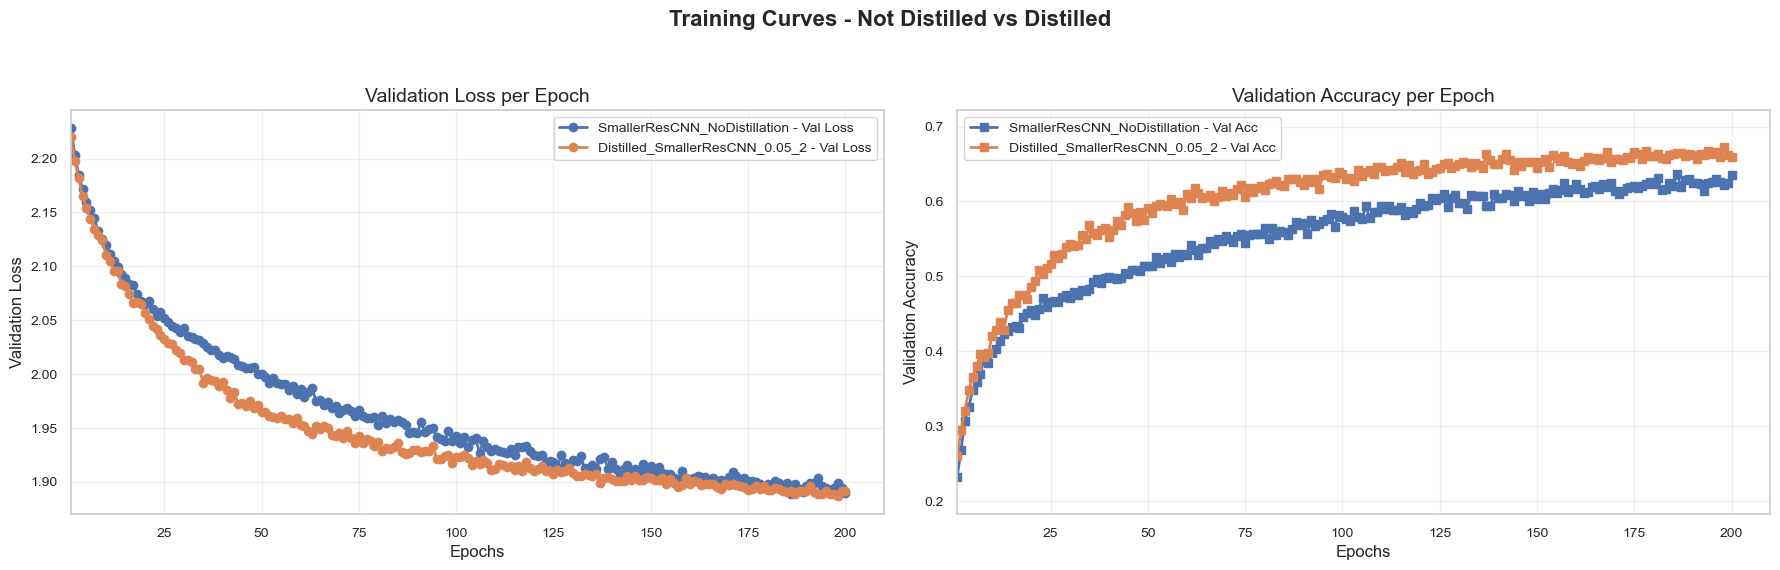

In [ ]:
DLModel.plot_multiple_training_curves(
    [smaller_res_cnn, distilled_model],
    title='Training Curves - Not Distilled vs Distilled')

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.